In [1]:
for lib in [
    "python ",
    "numpy ",
    "pandas",
    "matplotlib ",
    "netw",
]:
    !pip freeze | grep {lib}

fastjsonschema @ file:///home/conda/feedstock_root/build_artifacts/python-fastjsonschema_1677336799617/work/dist
GitPython @ file:///home/conda/feedstock_root/build_artifacts/gitpython_1676637751542/work
ipython @ file:///Users/runner/miniforge3/conda-bld/ipython_1677617314627/work
ipython-genutils==0.2.0
python-dateutil @ file:///home/conda/feedstock_root/build_artifacts/python-dateutil_1626286286081/work
python-slugify @ file:///tmp/build/80754af9/python-slugify_1620405669636/work
xxhash @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_5dctqdmbn8/croot/python-xxhash_1667919512545/work
numpy @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d18vvv3mag/croot/numpy_and_numpy_base_1672336185310/work
pandas==1.5.3
matplotlib @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c08pvf1yzu/croot/matplotlib-suite_1677674309145/work
matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/wo

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm as tn

In [3]:
DEFAULT_PERCENTILES = [.01, .05, .1, .25, .5, .75, .9, .95, .99]
DEFAULT_PERCENTILES

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [4]:
from scipy.optimize import curve_fit

Scale-free network has a Power law degree distribution. Let us take a closer look at this distribution. The PDF of the Power law is 

$$ p(x) = Cx^{-\alpha},$$ 

where $C$ is a normalization constant 

$$C = \frac{\alpha - 1}{x_{\text{min}}^{-\alpha + 1}}$$ 

and $\alpha>1$ is called an exponent of the distribution. 

In [5]:
# Define power law function
def power_law(x, alpha, C):
    return C * np.power(x, -alpha)

In [6]:
# define function to calculate GCC size
def calculate_gcc_size(network):
    return len(max(nx.connected_components(network), key=len))

# define function to simulate targeted attack on network
def targeted_attack(network, centrality_measure, p):
    sorted_nodes = centrality_measure.sort_values(ascending=False)
    nodes_to_remove = sorted_nodes[:int(p * len(network))].index.map(int)
    network.remove_nodes_from(nodes_to_remove)
    return network

# define function to simulate random attack on network
def random_attack(network, p):
    nodes_to_remove = set(np.random.choice(network.nodes, size=int(p * len(network)), replace=False))
    network.remove_nodes_from(nodes_to_remove)
    return network

In [7]:
def alpha_lin_bins(x_train, bins):
    hist, bin_edges = np.histogram(x_train, bins=bins, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    idx = np.argwhere(hist > 0)
    x1 = np.log(bin_centers[idx])[:, 0]
    x2 = np.ones(len(idx))
    X = np.stack([x1, x2], axis=1)
    y = np.log(hist[idx])
    alpha, intercept = (np.linalg.pinv(X) @ y)[:, 0]
    alpha *= -1
    return alpha, intercept

### Load and read Power Grid data

Data, as mentioned here https://github.com/bdw/GridKit, are provided by zenodo:

https://zenodo.org/record/47317:

- Europe https://zenodo.org/record/47317/files/gridkit_euorpe.zip
- North America https://zenodo.org/record/47317/files/gridkit_north_america.zip

In [13]:
!wget https://zenodo.org/record/47317/files/gridkit_euorpe.zip
!wget https://zenodo.org/record/47317/files/gridkit_north_america.zip

--2023-03-25 15:53:11--  https://zenodo.org/record/47317/files/gridkit_euorpe.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1805506 (1.7M) [application/octet-stream]
Saving to: 'gridkit_euorpe.zip'

gridkit_euorpe.zip  100%[===================>]   1.72M  2.73MB/s    in 0.6s    

2023-03-25 15:53:13 (2.73 MB/s) - 'gridkit_euorpe.zip' saved [1805506/1805506]

--2023-03-25 15:53:13--  https://zenodo.org/record/47317/files/gridkit_north_america.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1895742 (1.8M) [application/octet-stream]
Saving to: 'gridkit_north_america.zip'

gridkit_north_ameri 100%[===================>]   1.81M  2.94MB/s    in 0.6s    

2023-03-25 15:53:15 (2.94 MB/s) - 'gridkit_north_america.zip' saved [189

In [14]:
!unzip gridkit_euorpe.zip -d gridkit
!unzip gridkit_north_america.zip -d gridkit

Archive:  gridkit_euorpe.zip
  inflating: gridkit/gridkit_europe-highvoltage-links.csv  
  inflating: gridkit/gridkit_europe-highvoltage-vertices.csv  
Archive:  gridkit_north_america.zip
  inflating: gridkit/gridkit_north_america-highvoltage-links.csv  
  inflating: gridkit/gridkit_north_america-highvoltage-vertices.csv  


In [15]:
!ls -halF ./gridkit

total 19928
drwxr-xr-x   6 ihorolkhovatyi  staff   192B 25 бер 15:53 ./
drwx------@ 24 ihorolkhovatyi  staff   768B 25 бер 15:53 ../
-rw-rw-r--   1 ihorolkhovatyi  staff   2,9M 10 бер  2016 gridkit_europe-highvoltage-links.csv
-rw-rw-r--   1 ihorolkhovatyi  staff   1,7M 10 бер  2016 gridkit_europe-highvoltage-vertices.csv
-rw-rw-r--   1 ihorolkhovatyi  staff   3,3M 10 бер  2016 gridkit_north_america-highvoltage-links.csv
-rw-rw-r--   1 ihorolkhovatyi  staff   1,8M 10 бер  2016 gridkit_north_america-highvoltage-vertices.csv


### EU

In [16]:
eu_nodes_df = pd.read_csv("./gridkit/gridkit_europe-highvoltage-vertices.csv")
eu_nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   v_id           13871 non-null  int64  
 1   lon            13871 non-null  float64
 2   lat            13871 non-null  float64
 3   typ            13871 non-null  object 
 4   voltage        8032 non-null   object 
 5   frequency      2985 non-null   object 
 6   name           5193 non-null   object 
 7   operator       4757 non-null   object 
 8   ref            1859 non-null   object 
 9   wkt_srid_4326  13871 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.1+ MB


In [17]:
eu_nodes_df.sample(5).T

1734  \
v_id                                                       57036   
lon                                                     3.955029   
lat                                                     47.79709   
typ                                                        joint   
voltage                                                   225000   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     RTE   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(3.95502905073119 47.7970896790...   

                                                            4657  \
v_id                                                       27039   
lon                                                     2.878034   
lat                                                    42.058752   
typ                                                        joint   
voltage                                                   400000   
frequency                                                    NaN   
name                             Línia de Molt Alta Tensió (MAT)   
operator                                 Red Eléctrica de España   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(2.87803409552929 42.0587519627...   

                                                            5253  \
v_id                                                       53992   
lon                                                     3.069697   
lat                                                    50.216021   
typ                                                        merge   
voltage                                                      NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(3.06969656447101 50.2160205149...   

                                                            8077  \
v_id                                                       38190   
lon                                                    12.941836   
lat                                                     46.07914   
typ                                                   substation   
voltage                                                      NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(12.9418362690076 46.0791403251...   

                                                            3294  
v_id                                                       61647  
lon                                                     8.012052  
lat                                                    51.425723  
typ                                                        joint  
voltage                              380000;380000;110000;110000  
frequency                                                     50  
name                                                         NaN  
operator                                                     RWE  
ref                                                         4315  
wkt_srid_4326  SRID=4326;POINT(8.01205245949519 51.4257232890...

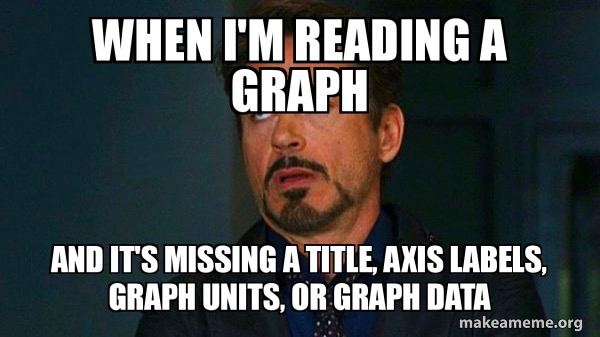

In [18]:
eu_nodes_df["typ"].value_counts()

joint          6398
substation     4902
merge           955
station         760
sub_station     736
plant           120
Name: typ, dtype: int64

In [19]:
eu_nodes_df.describe()

v_id           lon           lat
count  13871.000000  13871.000000  13871.000000
mean   35859.127460     12.904049     48.549409
std    19606.625707     12.340785      6.146771
min        6.000000    -22.018902     36.032347
25%    20769.500000      5.551419     44.645626
50%    34179.000000     10.695901     48.022867
75%    54703.000000     19.450283     51.658862
max    68195.000000     44.982275     69.906346

In [20]:
eu_links_df = pd.read_csv("./gridkit/gridkit_europe-highvoltage-links.csv")
eu_links_df = eu_links_df.dropna(axis=1, how="all")
eu_links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18804 entries, 0 to 18803
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   l_id           18804 non-null  int64  
 1   v_id_1         18804 non-null  int64  
 2   v_id_2         18804 non-null  int64  
 3   voltage        13483 non-null  object 
 4   cables         13373 non-null  object 
 5   wires          6042 non-null   object 
 6   frequency      4546 non-null   object 
 7   name           4328 non-null   object 
 8   operator       6324 non-null   object 
 9   ref            3371 non-null   object 
 10  length_m       18804 non-null  float64
 11  wkt_srid_4326  18804 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 1.7+ MB


In [21]:
eu_links_df.sample(5).T

2654   \
l_id                                                       37788   
v_id_1                                                     48911   
v_id_2                                                     31891   
voltage                                                      NaN   
cables                                                       NaN   
wires                                                        NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                             3043.341963   
wkt_srid_4326  SRID=4326;LINESTRING(-3.59530682495885 39.0707...   

                                                           15249  \
l_id                                                       34824   
v_id_1                                                     46466   
v_id_2                                                     25495   
voltage                                                      NaN   
cables                                                       NaN   
wires                                                        NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                            27069.876111   
wkt_srid_4326  SRID=4326;LINESTRING(26.4059503327915 47.96508...   

                                                           4201   \
l_id                                                       15074   
v_id_1                                                     56473   
v_id_2                                                     62161   
voltage                                                      NaN   
cables                                                       NaN   
wires                                                        NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                              306.038103   
wkt_srid_4326  SRID=4326;LINESTRING(6.58749258350282 51.05324...   

                                                           10848  \
l_id                                                       36724   
v_id_1                                                     25713   
v_id_2                                                     25714   
voltage                                                      NaN   
cables                                                       NaN   
wires                                                        NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                              304.768136   
wkt_srid_4326  SRID=4326;LINESTRING(13.04692125027 46.0527252...   

                                                           4659   
l_id                                                        4263  
v_id_1                                                     54104  
v_id_2                                                     62986  
voltage                                                   110000  
cables                                                         6  
wires                                                        NaN  
frequency                                         

In [22]:
g_eu = nx.Graph()
g_eu

In [23]:
for v1, v2 in zip(eu_links_df["v_id_1"], eu_links_df["v_id_2"]):
    g_eu.add_edge(v1, v2)
g_eu.number_of_nodes(), g_eu.number_of_edges()

(13844, 17277)

In [24]:
nx.set_node_attributes(g_eu, eu_nodes_df.set_index("v_id")[["lon", "lat", "name", "typ"]].to_dict("index"))

In [25]:
pos_eu = {k: (v["lon"], v["lat"]) for k, v in g_eu.nodes.data()}
len(pos_eu)

13844

In [26]:
groups_eu = set(nx.get_node_attributes(g_eu, 'typ').values())
mapping_eu = {v: k for k, v in enumerate(sorted(groups_eu))}
node_color_eu = [mapping_eu[v["typ"]] for k, v in g_eu.nodes.data()]
len(node_color_eu)

13844

In [27]:
mapping_eu

{'joint': 0,
 'merge': 1,
 'plant': 2,
 'station': 3,
 'sub_station': 4,
 'substation': 5}

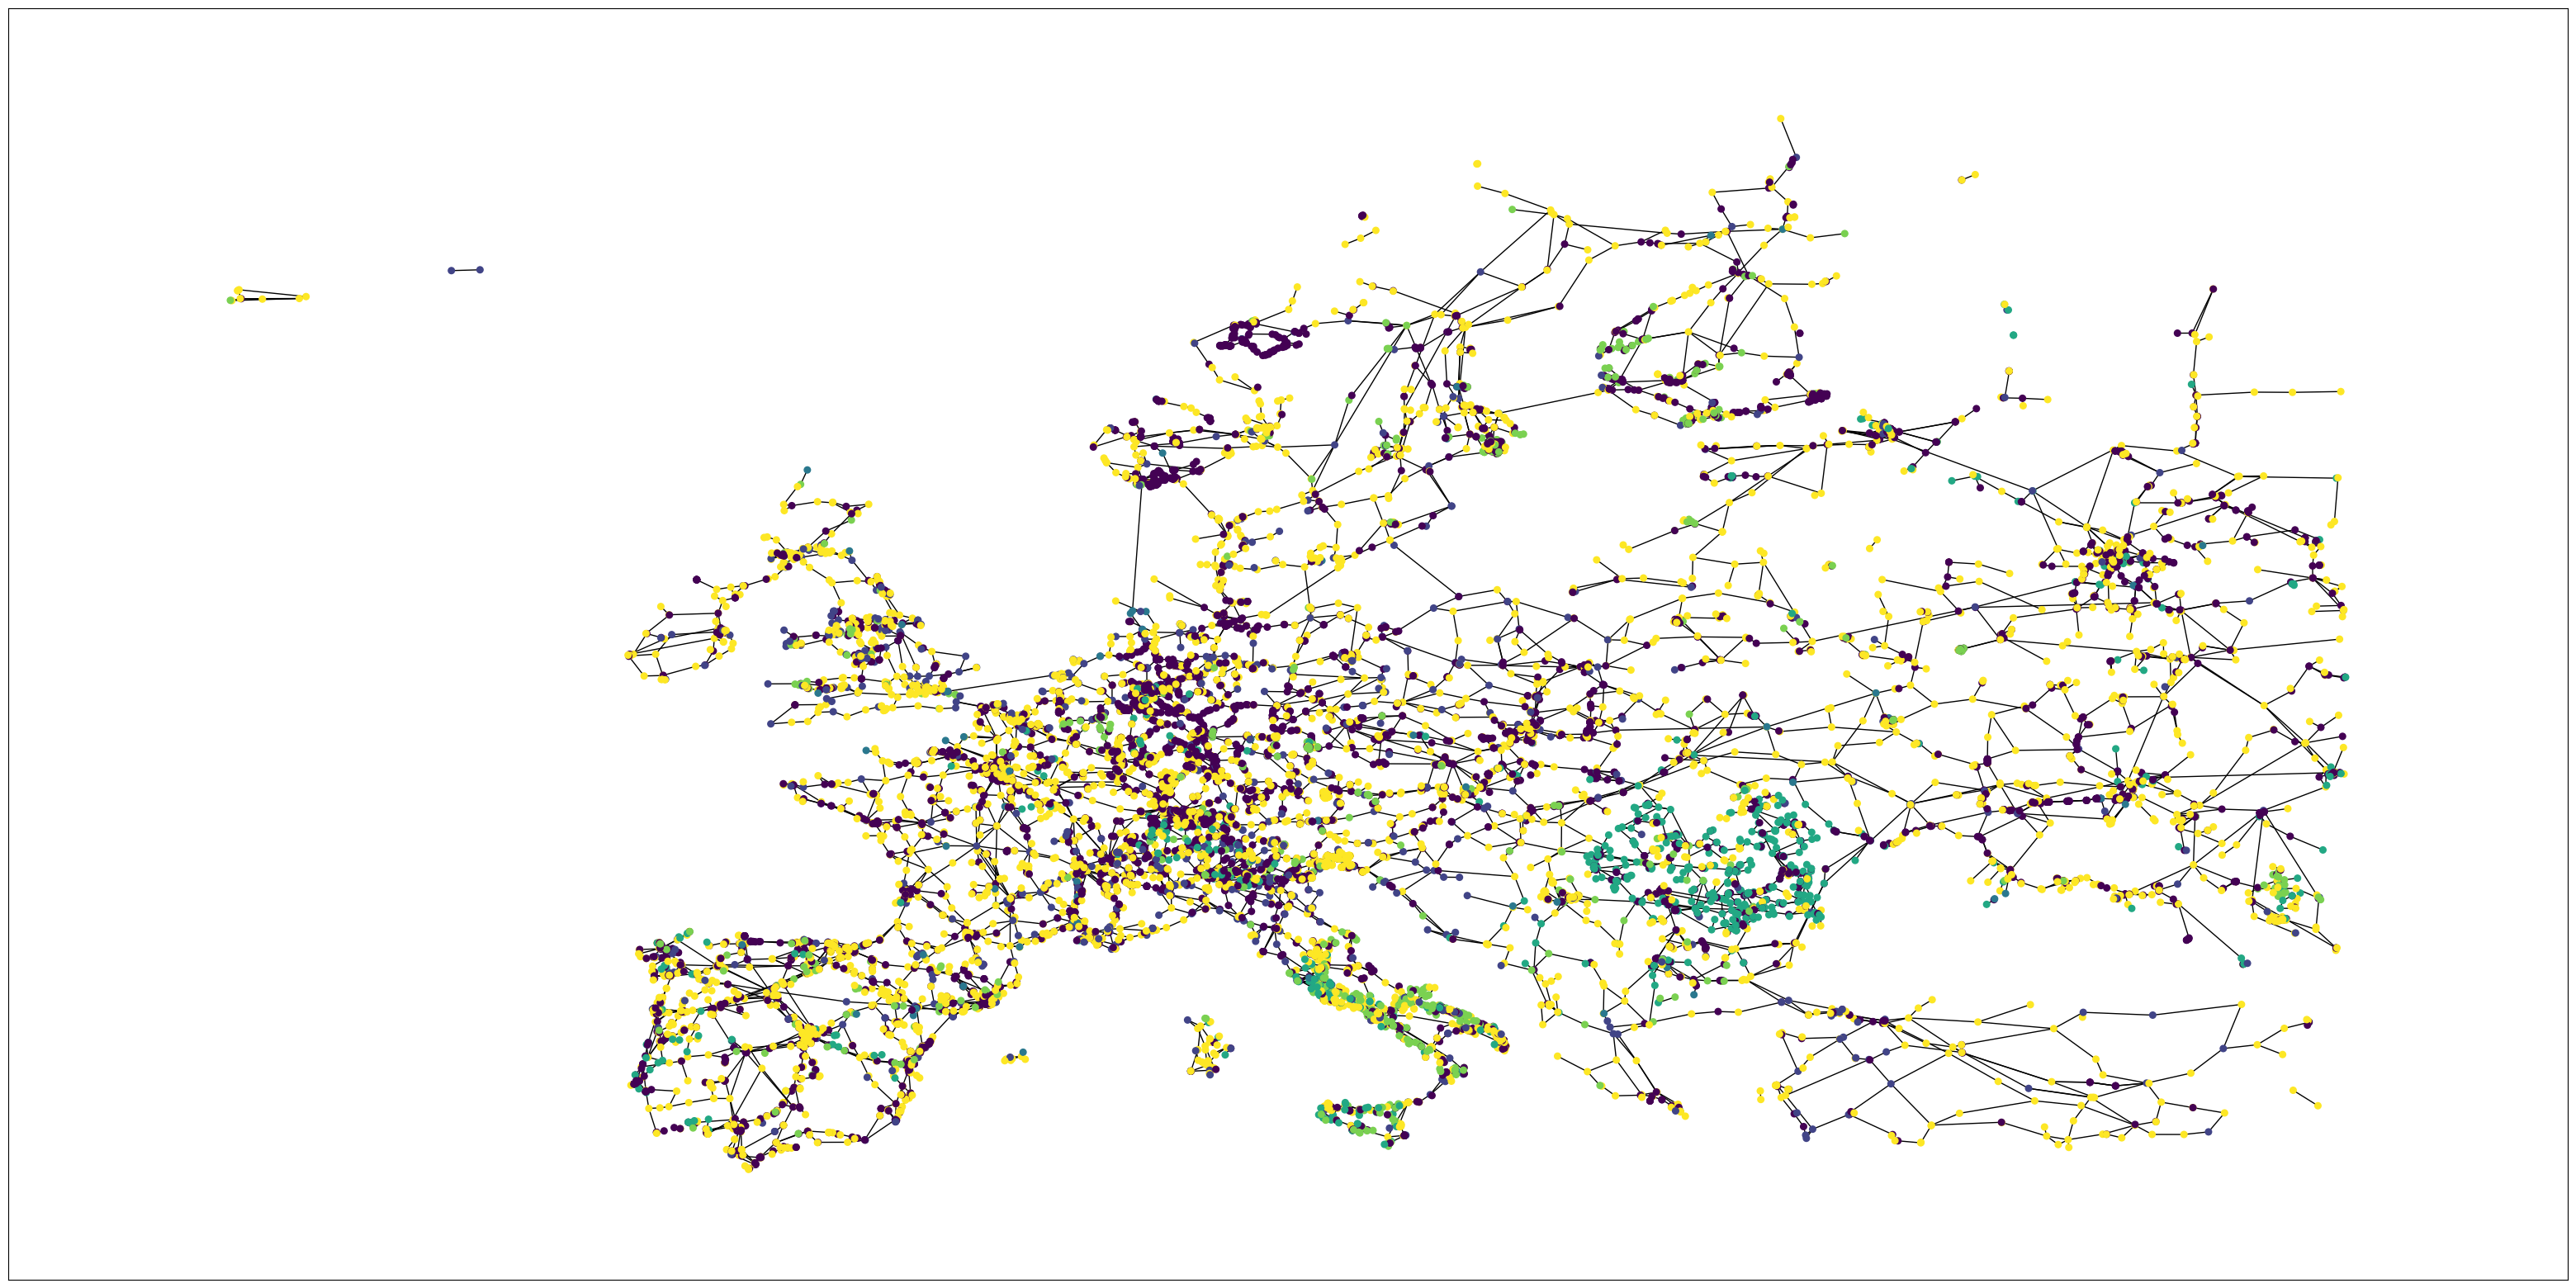

In [28]:
plt.figure(figsize=(40, 20))
nx.draw_networkx(
    g_eu,
    pos=pos_eu,
    with_labels=False,
    node_color=node_color_eu,
    node_size=30#[(v + 0.001) * 0.001 for v in nx.get_node_attributes(g_eu, "bc")]
)

In [29]:
gccs_eu = sorted(nx.connected_components(g_eu), key=len, reverse=True)
len(gccs_eu)

59

In [30]:
for tmp_g in gccs_eu:
    tmp_g = nx.subgraph(g_eu, tmp_g)
    print(tmp_g.number_of_nodes(), tmp_g.number_of_edges())

13478 16922
49 59
37 39
26 33
21 24
16 19
16 17
12 12
10 11
10 12
9 9
9 8
8 8
8 8
7 8
5 5
5 4
5 5
5 5
4 3
4 3
4 3
4 3
4 3
4 3
4 3
3 3
3 2
3 2
3 2
3 2
3 2
3 2
3 2
3 2
3 2
3 2
3 2
3 2
3 2
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1


In [31]:
gcc_eu = nx.subgraph(g_eu, gccs_eu[0])
# gcc_eu = nx.subgraph(g_eu, set(g_eu.nodes) - gccs_eu[0])  # oposite!
gcc_eu.number_of_nodes(), gcc_eu.number_of_edges()

(13478, 16922)

In [32]:
nx.set_node_attributes(g_eu, nx.degree_centrality(gcc_eu), "dc")
pd.Series(nx.get_node_attributes(gcc_eu, "dc").values()).describe(percentiles=DEFAULT_PERCENTILES)

count    13478.000000
mean         0.000186
std          0.000096
min          0.000074
1%           0.000074
5%           0.000074
10%          0.000074
25%          0.000148
50%          0.000148
75%          0.000223
90%          0.000297
95%          0.000371
99%          0.000594
max          0.001187
dtype: float64

In [37]:
%%time

# 10 or 30 mins!
nx.set_node_attributes(gcc_eu, nx.betweenness_centrality(gcc_eu, k=1_400), "bc")
pd.Series(nx.get_node_attributes(gcc_eu, "bc").values()).describe(percentiles=DEFAULT_PERCENTILES)

CPU times: user 1min 2s, sys: 126 ms, total: 1min 2s
Wall time: 1min 2s


count    1.347800e+04
mean     3.605790e-03
std      1.587324e-02
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
25%      1.236858e-07
50%      1.612321e-04
75%      1.098560e-03
90%      5.468583e-03
95%      1.557458e-02
99%      6.857852e-02
max      2.694931e-01
dtype: float64

In [39]:
nx.set_node_attributes(g_eu, nx.closeness_centrality(gcc_eu), "cc")
pd.Series(nx.get_node_attributes(gcc_eu, "cc").values()).describe(percentiles=DEFAULT_PERCENTILES)

TypeError: closeness_centrality() got an unexpected keyword argument 'k'

In [40]:
len(nx.algorithms.community.louvain_communities(gcc_eu))

78

In [41]:
tmp_mapping = {}

for i, tmp_nodes in enumerate(nx.algorithms.community.louvain_communities(gcc_eu)):
    for tmp_node in tmp_nodes:
        tmp_mapping[tmp_node] = i
len(tmp_mapping)

13478

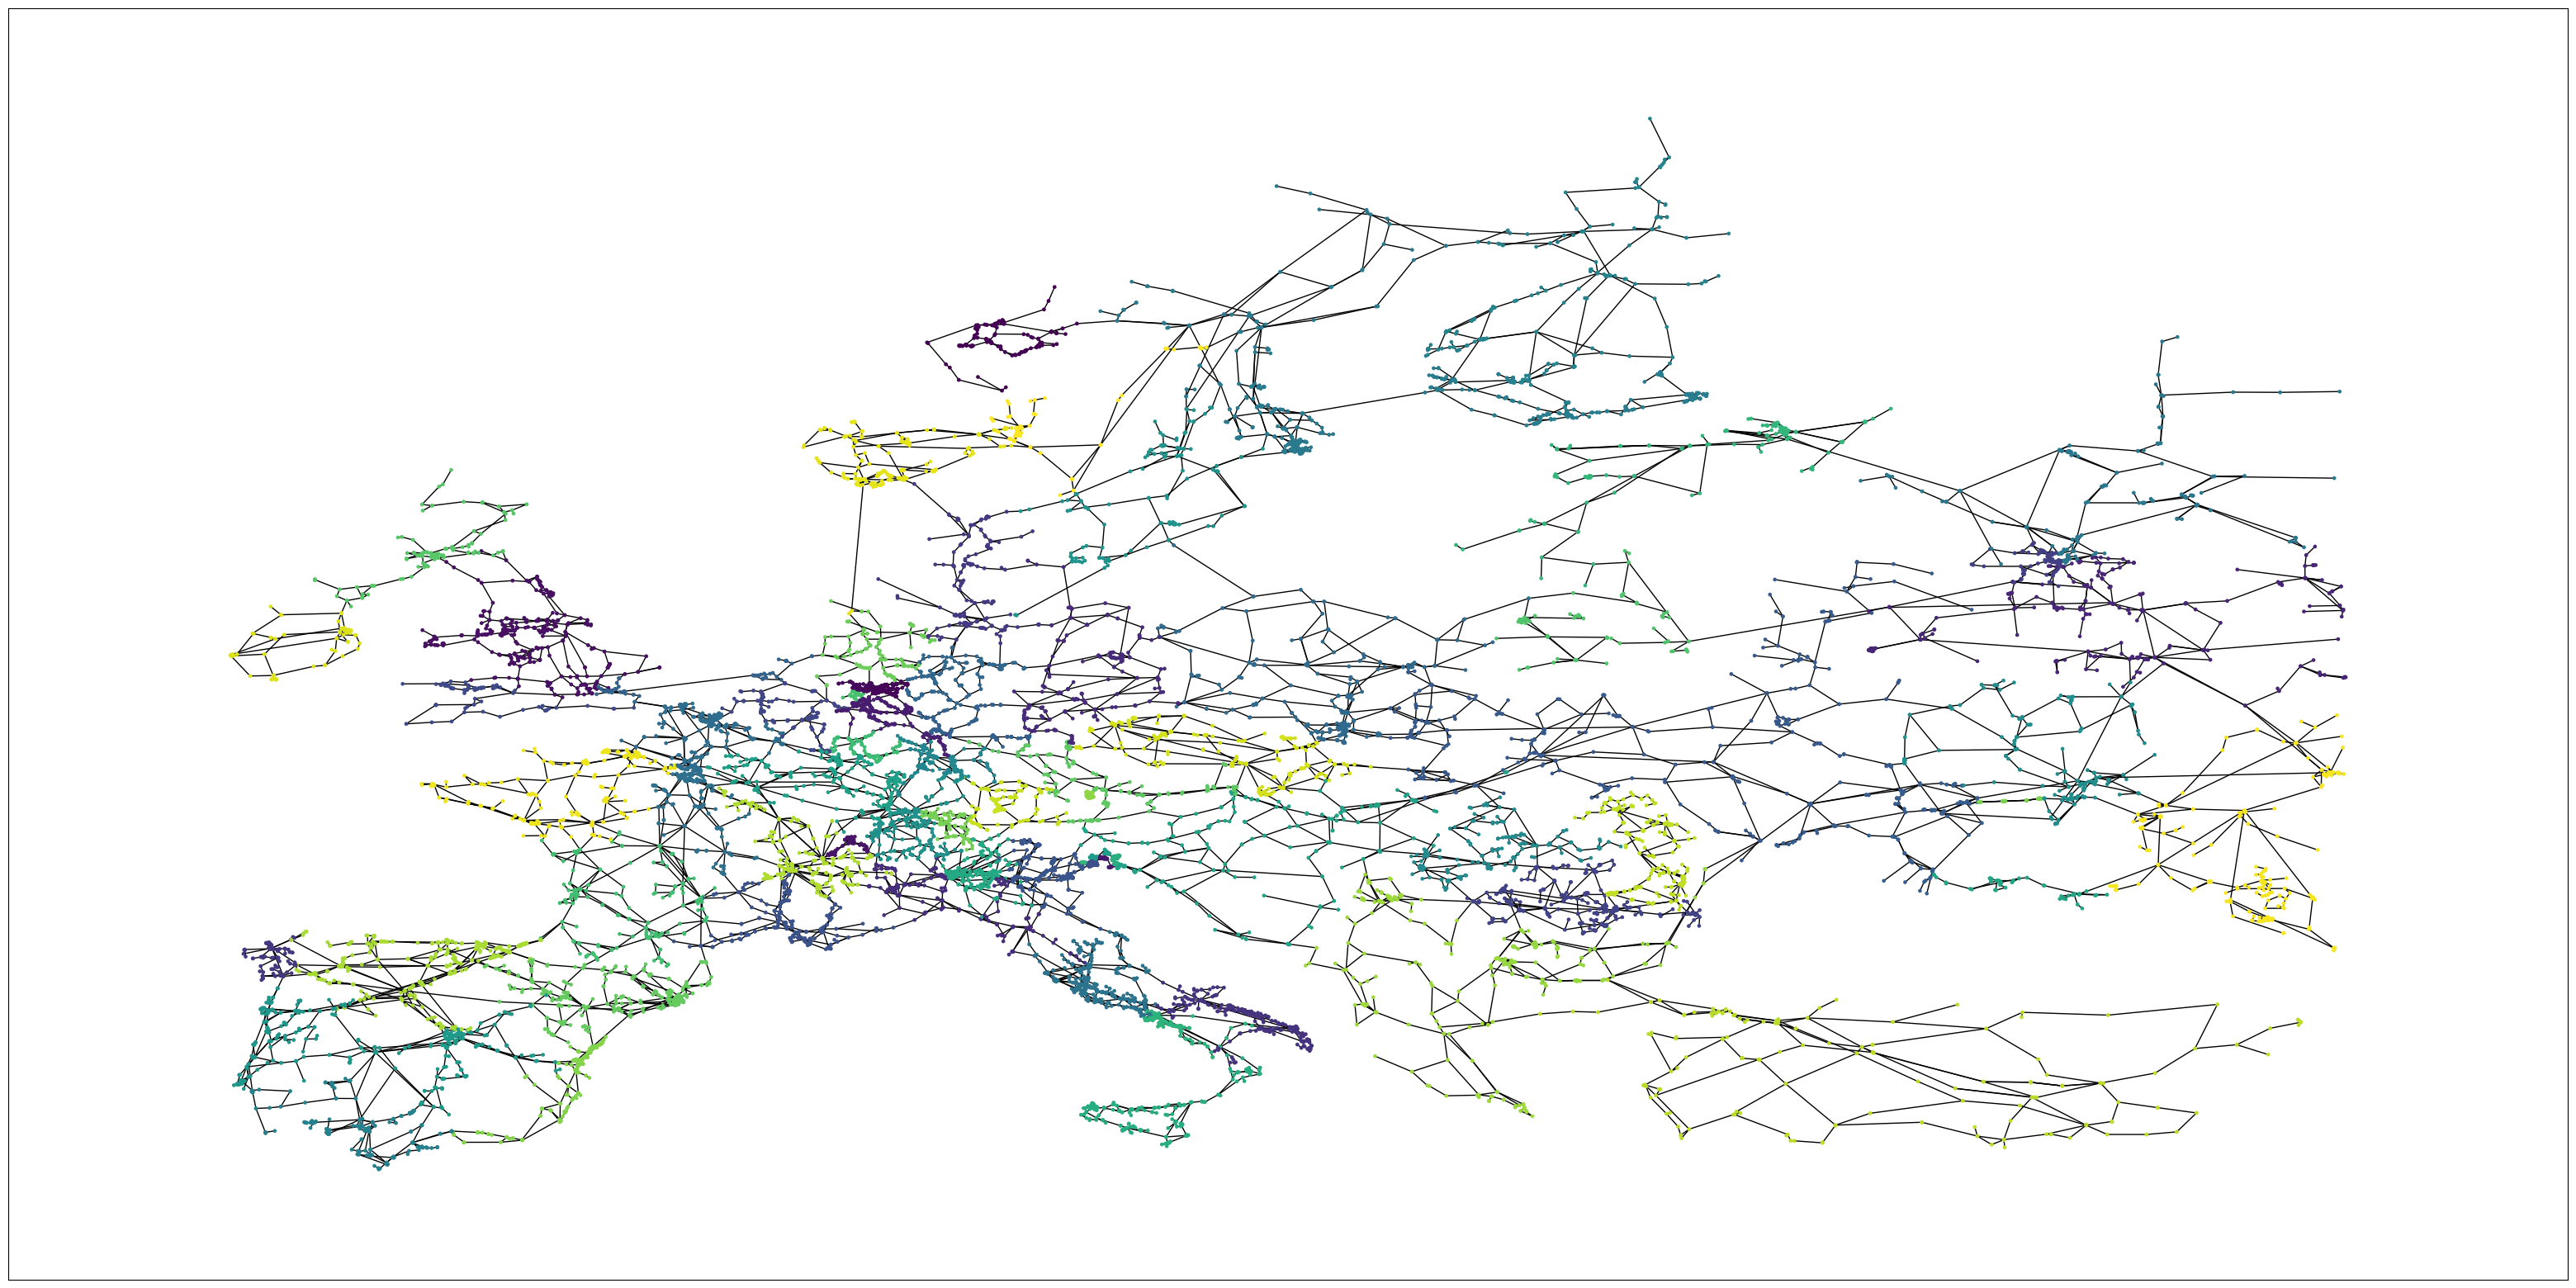

In [42]:
plt.figure(figsize=(40, 20))
nx.draw_networkx(
    gcc_eu,
    pos={k: (v["lon"], v["lat"]) for k, v in gcc_eu.nodes.data()},
    with_labels=False,
#     labels={k: (v["name"][:15] if isinstance(v["name"], str) else "") for k, v in gcc_eu.nodes.data()},
#     node_color=[mapping_eu[v["typ"]] for k, v in gcc_eu.nodes.data()],
    node_color=[tmp_mapping[k] for k in gcc_eu.nodes],
    node_size=[(v + 0.001) * 5000 for k, v in nx.get_node_attributes(g_eu, "dc").items() if k in gcc_eu.nodes]
)

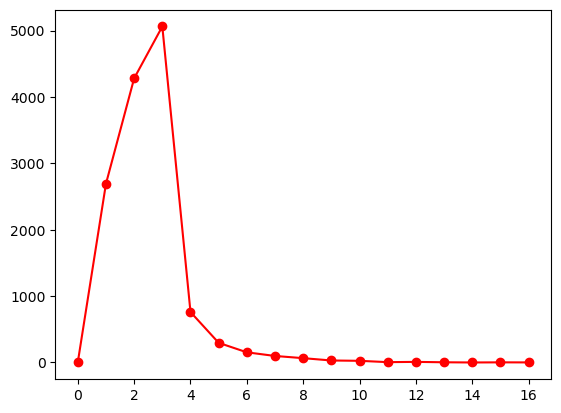

In [43]:
# degree_freq_eu = nx.degree_histogram(g_eu)
degree_freq_eu = nx.degree_histogram(gcc_eu)
degrees_eu = range(len(degree_freq_eu))
plt.plot(degrees_eu[:], degree_freq_eu[:],'ro-');

For Power Grids:

$$ p_k = \frac{e^{−k/⟨k⟩}}{⟨k⟩} $$

In [44]:
m = 0
m = 3

m

3

In [45]:
# Fit the degree distribution to the power law function using curve_fit
popt, pcov = curve_fit(power_law, degrees_eu[m:], degree_freq_eu[m:])
popt, pcov

(array([6.29358881e+00, 5.08818825e+06]),
 array([[3.74528887e-02, 2.10957166e+05],
        [2.10957166e+05, 1.19074769e+12]]))

In [46]:
# The first parameter of the fitted function is the exponent
alpha = popt[0]
alpha

6.293588811734771

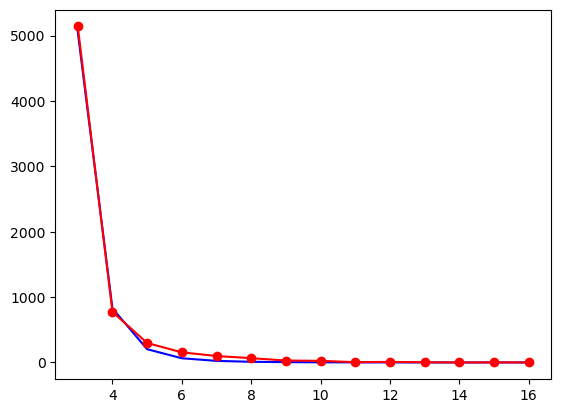

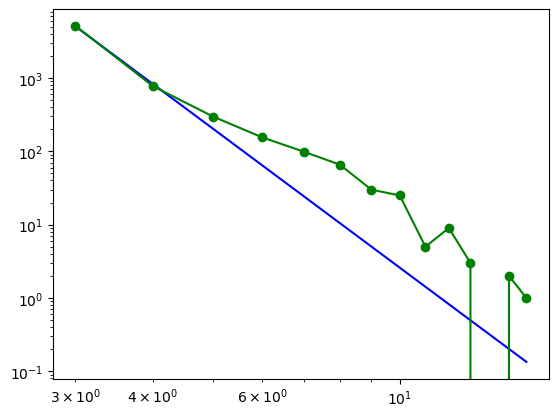

In [47]:
degree_freq_eu = nx.degree_histogram(g_eu)
degrees_eu = range(len(degree_freq_eu))
plt.plot(degrees_eu[m:], power_law(degrees_eu[m:], popt[0], popt[1]),'b-');
plt.plot(degrees_eu[m:], degree_freq_eu[m:],'ro-')
plt.show()
plt.plot(degrees_eu[m:], power_law(degrees_eu[m:], popt[0], popt[1]),'b-');
plt.loglog(degrees_eu[m:], degree_freq_eu[m:],'go-');

In [48]:
centralities_eu = {}

In [49]:
centralities_eu["Degree Centrality"] = pd.Series(nx.get_node_attributes(gcc_eu, "dc"))

In [50]:
centralities_eu["Degree Centrality"].sort_values(ascending=False).to_frame().join(eu_nodes_df.set_index("v_id"))

0        lon        lat          typ  \
39665  0.001187   2.432863  49.033856   substation   
54561  0.001113   2.866780  48.389318        merge   
20288  0.001113   2.689268  44.779259        merge   
20281  0.000965   5.804752  46.055954        merge   
54279  0.000965  -4.937592  41.789409        merge   
...         ...        ...        ...          ...   
67262  0.000074  19.198184  50.157410        joint   
44185  0.000074  11.595879  42.332784  sub_station   
12351  0.000074   7.077099  47.408522      station   
34082  0.000074  37.818671  47.971974        joint   
54756  0.000074  -6.985058  42.126153        merge   

                                    voltage frequency  \
39665                         400000;225000       NaN   
54561                   400000;225000;63000       NaN   
20288       63000;20000;400000;225000;63000       NaN   
20281  20000;400;400000;225000;150000;63000       NaN   
54279                  220000;400000;220000        50   
...                                     ...       ...   
67262                                   NaN       NaN   
44185                                   NaN       NaN   
12351                                   NaN       NaN   
34082                                   NaN       NaN   
54756                                   NaN       NaN   

                                                    name  \
39665                 Poste électrique de Plessis-Gassot   
54561                        Poste électrique du Chesnoy   
20288  Poste source de Rueyres;Poste électrique de Ru...   
20281                      Poste électrique de Génissiat   
54279                          Subestación de La Mudarra   
...                                                  ...   
67262                                                NaN   
44185                                                NaN   
12351                                                NaN   
34082                                                NaN   
54756  Central Hidráulica de San Sebastián;C.Hidráuli...   

                      operator  ref  \
39665                      RTE  NaN   
54561                      RTE  NaN   
20288                     ERDF  NaN   
20281                     ERDF  NaN   
54279  Red Eléctrica de España  NaN   
...                        ...  ...   
67262                      NaN  NaN   
44185                      RFI  NaN   
12351                      NaN  NaN   
34082                      NaN  NaN   
54756                      NaN  NaN   

                                           wkt_srid_4326  
39665  SRID=4326;POINT(2.43286302516388 49.0338563351...  
54561  SRID=4326;POINT(2.86678015773915 48.3893184801...  
20288  SRID=4326;POINT(2.68926783157466 44.7792593956...  
20281  SRID=4326;POINT(5.80475185831666 46.0559538031...  
54279  SRID=4326;POINT(-4.93759178518029 41.789408791...  
...                                                  ...  
67262  SRID=4326;POINT(19.1981835774723 50.157409886825)  
44185  SRID=4326;POINT(11.5958790930359 42.3327841683...  
12351  SRID=4326;POINT(7.07709864689585 47.4085219939...  
34082  SRID=4326;POINT(37.8186713755107 47.9719735614...  
54756  SRID=4326;POINT(-6.9850583528959 42.1261528770...  

[13478 rows x 10 columns]

In [51]:
centralities_eu["Betweenness Centrality"] = pd.Series(nx.get_node_attributes(gcc_eu, "bc"))

In [52]:
centralities_eu["Betweenness Centrality"].sort_values(ascending=False).to_frame().join(eu_nodes_df.set_index("v_id"))

0        lon        lat         typ               voltage  \
54736  0.269493  13.471656  45.852256       merge                380000   
5159   0.265010  11.300072  45.381571  substation                380000   
55425  0.259101   7.935914  45.233227       merge                380000   
6465   0.258902  13.968758  45.691280  substation  400000;220000;110000   
20710  0.255858  11.140158  45.060026       merge                380000   
...         ...        ...        ...         ...                   ...   
48512  0.000000  26.926258  46.943907     station                   NaN   
17238  0.000000  17.089234  48.117691  substation                   NaN   
34158  0.000000   8.865333  47.324024       joint                   NaN   
32160  0.000000  19.324999  51.269595       joint                400000   
54756  0.000000  -6.985058  42.126153       merge                   NaN   

      frequency                                               name operator  \
54736       NaN                                         Redipuglia    Terna   
5159        NaN                                             Dugale    Terna   
55425       NaN                Laboratori Cesi Chivasso;Rondissone     Cesi   
6465        NaN                                         RTP Divača      NaN   
20710       NaN       Ostiglia;Centrale termoelettrica di Ostiglia     E.On   
...         ...                                                ...      ...   
48512       NaN                                                NaN      NaN   
17238       NaN                                                NaN      NaN   
34158       NaN                                                NaN      NaN   
32160       NaN  400kV Elektrownia Bełchatów - Rogowiec x2;400k...      NaN   
54756       NaN  Central Hidráulica de San Sebastián;C.Hidráuli...      NaN   

       ref                                      wkt_srid_4326  
54736  NaN  SRID=4326;POINT(13.4716557711565 45.8522564610...  
5159   NaN  SRID=4326;POINT(11.3000716955976 45.3815712372...  
55425  NaN  SRID=4326;POINT(7.93591360078911 45.2332266685...  
6465   NaN  SRID=4326;POINT(13.9687577838935 45.6912801294...  
20710  NaN  SRID=4326;POINT(11.1401579257413 45.0600255286...  
...    ...                                                ...  
48512  NaN  SRID=4326;POINT(26.9262575101639 46.9439065494...  
17238  NaN  SRID=4326;POINT(17.0892344694416 48.1176905442...  
34158  NaN  SRID=4326;POINT(8.86533349162276 47.3240239650...  
32160  NaN  SRID=4326;POINT(19.3249992851206 51.2695947109...  
54756  NaN  SRID=4326;POINT(-6.9850583528959 42.1261528770...  

[13478 rows x 10 columns]

In [57]:
centralities_eu["Eigenvector Centrality"] = pd.Series(nx.eigenvector_centrality(gcc_eu, max_iter=1000))

In [58]:
centralities_eu["Eigenvector Centrality"].sort_values(ascending=False).to_frame().join(eu_nodes_df.set_index("v_id"))

0        lon        lat         typ  \
39665  5.706438e-01   2.432863  49.033856  substation   
45847  2.756048e-01   2.575600  48.976139  substation   
5638   2.321571e-01   2.258941  49.217602  substation   
32899  2.111696e-01   2.524161  48.983321       joint   
21201  1.939324e-01   2.662621  48.904488       merge   
...             ...        ...        ...         ...   
25607  4.755796e-33  12.711366  45.948066       joint   
37862  4.283676e-33  12.701299  45.951450  substation   
4589   4.110475e-33  -3.742906  58.580141       plant   
3802   1.059222e-33  12.710301  45.947560  substation   
21219  1.059222e-33  12.713496  45.946306       merge   

                         voltage frequency  \
39665              400000;225000       NaN   
45847              400000;225000       NaN   
5638                      400000       NaN   
32899                     225000       NaN   
21201  400000;225000;63000;20000       NaN   
...                          ...       ...   
25607                        NaN       NaN   
37862                        NaN       NaN   
4589                         NaN       NaN   
3802                         NaN       NaN   
21219                        NaN       NaN   

                                                    name operator  ref  \
39665                 Poste électrique de Plessis-Gassot      RTE  NaN   
45847                        Poste électrique de Sausset      RTE  NaN   
5638                         Poste électrique de Terrier      RTE  NaN   
32899                                                NaN      RTE  NaN   
21201  Poste électrique de Villevaudé;Poste source de...      RTE  NaN   
...                                                  ...      ...  ...   
25607                                                NaN      NaN  NaN   
37862                                                NaN      NaN  NaN   
4589    Dounreay Nuclear Power Development Establishment    UKAEA  NaN   
3802                                                 NaN      NaN  NaN   
21219                                                NaN      NaN  NaN   

                                           wkt_srid_4326  
39665  SRID=4326;POINT(2.43286302516388 49.0338563351...  
45847  SRID=4326;POINT(2.57559960916253 48.9761385998...  
5638   SRID=4326;POINT(2.2589411859609 49.2176015501642)  
32899  SRID=4326;POINT(2.52416057599303 48.9833211156...  
21201  SRID=4326;POINT(2.66262106400429 48.9044879342...  
...                                                  ...  
25607  SRID=4326;POINT(12.711366086176 45.9480657963458)  
37862  SRID=4326;POINT(12.7012994875027 45.9514499985...  
4589   SRID=4326;POINT(-3.74290649926517 58.580140523...  
3802   SRID=4326;POINT(12.7103012568171 45.9475602560...  
21219  SRID=4326;POINT(12.7134963434775 45.9463059536...  

[13478 rows x 10 columns]

In [54]:
centralities_eu["PageRank"] = pd.Series(nx.pagerank(gcc_eu))

In [55]:
centralities_eu["PageRank"].sort_values(ascending=False).to_frame().join(eu_nodes_df.set_index("v_id"))

0        lon        lat         typ  \
20288  0.000362   2.689268  44.779259       merge   
39665  0.000339   2.432863  49.033856  substation   
54561  0.000321   2.866780  48.389318       merge   
54173  0.000304  12.688571  42.555733       merge   
39555  0.000296  12.530776  41.719941  substation   
...         ...        ...        ...         ...   
39428  0.000029   2.543295  48.914950  substation   
46889  0.000029  -9.102002  38.868021     station   
7546   0.000029   2.944428  48.415487  substation   
41464  0.000029   4.916275  45.764967  substation   
6404   0.000029   4.899104  45.865161  substation   

                               voltage frequency  \
20288  63000;20000;400000;225000;63000       NaN   
39665                    400000;225000       NaN   
54561              400000;225000;63000       NaN   
54173                           380000       NaN   
39555                           380000       NaN   
...                                ...       ...   
39428                              NaN       NaN   
46889                              NaN       NaN   
7546                      225000;25000       NaN   
41464               225000;63000;20000       NaN   
6404                               NaN       NaN   

                                                    name operator  ref  \
20288  Poste source de Rueyres;Poste électrique de Ru...     ERDF  NaN   
39665                 Poste électrique de Plessis-Gassot      RTE  NaN   
54561                        Poste électrique du Chesnoy      RTE  NaN   
54173                                         Villavalle      NaN  NaN   
39555                                           Roma Sud      NaN  NaN   
...                                                  ...      ...  ...   
39428                                                NaN      NaN  NaN   
46889                                                NaN      NaN  NaN   
7546                          Sous-station de la Voulzie     SNCF  NaN   
41464                         Poste électrique de Cusset      RTE  NaN   
6404          Poste électrique de Cailloux sur Fontaines      NaN  NaN   

                                           wkt_srid_4326  
20288  SRID=4326;POINT(2.68926783157466 44.7792593956...  
39665  SRID=4326;POINT(2.43286302516388 49.0338563351...  
54561  SRID=4326;POINT(2.86678015773915 48.3893184801...  
54173  SRID=4326;POINT(12.6885706660064 42.5557329137...  
39555  SRID=4326;POINT(12.5307755266279 41.7199409974...  
...                                                  ...  
39428  SRID=4326;POINT(2.54329458740803 48.9149495446...  
46889  SRID=4326;POINT(-9.10200181429757 38.868021149...  
7546   SRID=4326;POINT(2.94442841063663 48.4154867582...  
41464  SRID=4326;POINT(4.91627509600274 45.7649674936...  
6404   SRID=4326;POINT(4.89910417143152 45.8651606229...  

[13478 rows x 10 columns]

In [ ]:
scipy.stats.kendalltau

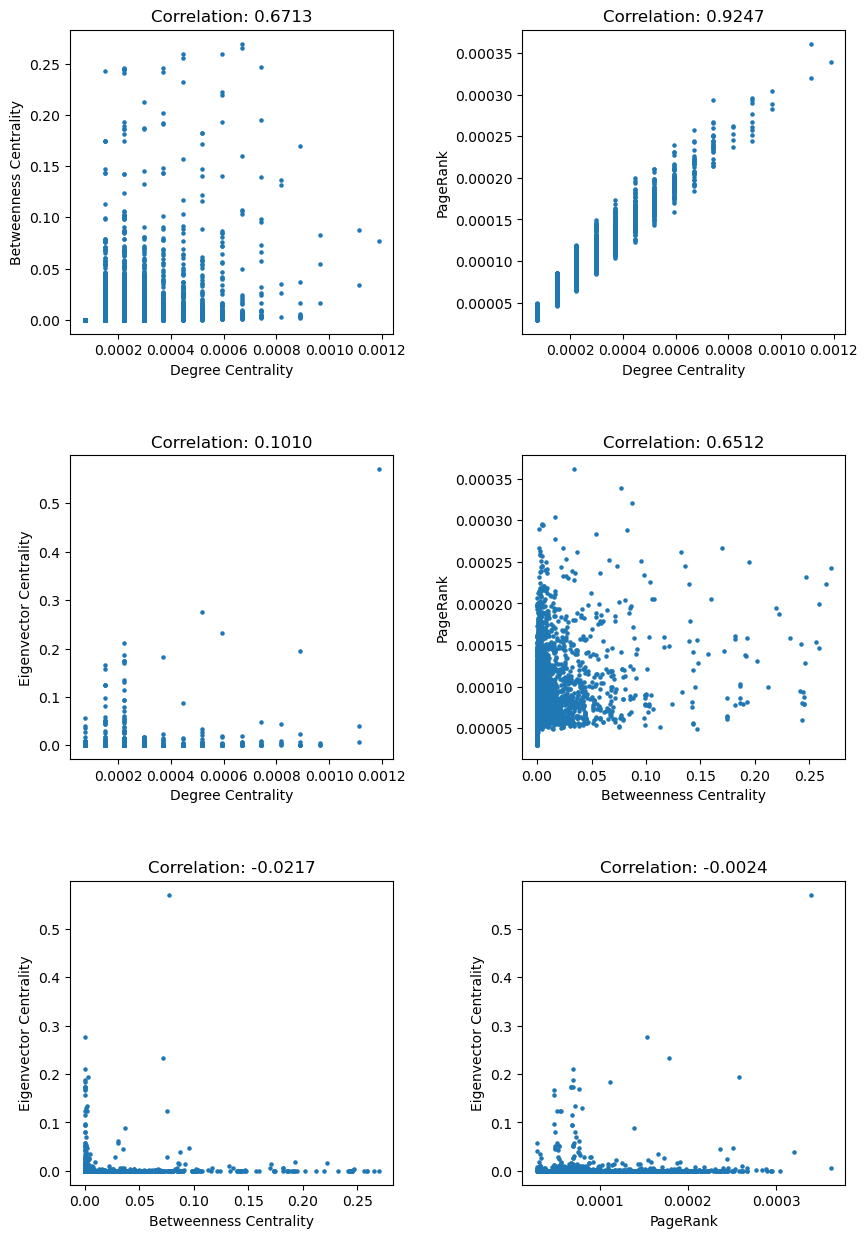

In [69]:
import scipy

plt.figure(figsize=(2*5, 3*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(centralities_eu)):
    for j in range(i + 1, len(centralities_eu)):
        i_label, i_vals = list(centralities_eu.items())[i]
        j_label, j_vals = list(centralities_eu.items())[j]
        #correlation = np.corrcoef([i_vals, j_vals])[0][1]
        correlation = scipy.stats.kendalltau(i_vals, j_vals)[0]
        correlation = scipy.stats.spearmanr(i_vals, j_vals)[0]
        plt.subplot(3, 2, k)
        plt.scatter(i_vals, j_vals, s=5)
        plt.title('Correlation: {:.4f}'.format(correlation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

In [67]:
p_values = np.arange(0, 0.3, 0.01)
random_gcc_eu_sizes = []
degree_gcc_eu_sizes = []
betweenness_gcc_eu_sizes = []
eigenvector_gcc_eu_sizes = []
pagerank_gcc_eu_sizes = []

for p in p_values:
    # simulate random attack
    network_copy = gcc_eu.copy()
    network_copy = random_attack(network_copy, p)
    random_gcc_eu_sizes.append(calculate_gcc_size(network_copy))

    # simulate targeted attacks
    for centrality_name, centrality_measure in centralities_eu.items():
        network_copy = gcc_eu.copy()
        network_copy = targeted_attack(network_copy, centrality_measure, p)
        if centrality_name == 'Degree Centrality':
            degree_gcc_eu_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'Betweenness Centrality':
            betweenness_gcc_eu_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'Eigenvector Centrality':
            eigenvector_gcc_eu_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'PageRank':
            pagerank_gcc_eu_sizes.append(calculate_gcc_size(network_copy))

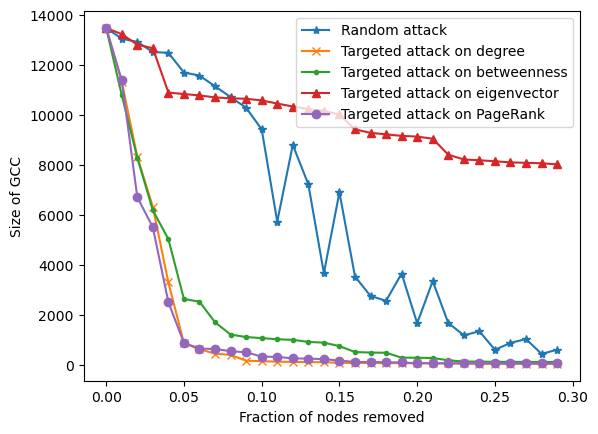

In [70]:
plt.plot(p_values, random_gcc_eu_sizes, label="Random attack", marker="*")
plt.plot(p_values, degree_gcc_eu_sizes, label="Targeted attack on degree", marker="x")
plt.plot(p_values, betweenness_gcc_eu_sizes, label="Targeted attack on betweenness", marker=".")
plt.plot(p_values, eigenvector_gcc_eu_sizes, label="Targeted attack on eigenvector", marker="^")
plt.plot(p_values, pagerank_gcc_eu_sizes, label="Targeted attack on PageRank", marker="o")
plt.xlabel("Fraction of nodes removed")
plt.ylabel("Size of GCC")
plt.legend()
plt.show()

In [ ]:
# task

In [136]:
# define function to simulate targeted attack on network
def targeted_attack_edge(network, centrality_measure, p):
    sorted_edges = centrality_measure.sort_values(ascending=False)
    edges_to_remove = sorted_edges[:int(p * len(network))].index.map(int)
    network.remove_edges_from(edges_to_remove)
    return network

def random_attack_edge(network, p):
    edges_to_remove = set(np.random.choice(network.edges, size=int(p * len(network)), replace=False),
                          np.random.choice(network.edges, size=int(p * len(network)), replace=False))
    network.remove_edges_from(edges_to_remove)
    return network

In [137]:
p_values = np.arange(0, 0.3, 0.01)
random_gcc_eu_sizes = []
degree_gcc_eu_sizes = []
betweenness_gcc_eu_sizes = []
eigenvector_gcc_eu_sizes = []
pagerank_gcc_eu_sizes = []

for p in p_values:
    # simulate random attack
    network_copy = gcc_eu.copy()
    network_copy = random_attack_edge(network_copy, p)
    random_gcc_eu_sizes.append(calculate_gcc_size(network_copy))

    # simulate targeted attacks
    for centrality_name, centrality_measure in centralities_eu.items():
        network_copy = gcc_eu.copy()
        network_copy = targeted_attack_edge(network_copy, centrality_measure, p)
        if centrality_name == 'Degree Centrality':
            degree_gcc_eu_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'Betweenness Centrality':
            betweenness_gcc_eu_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'Eigenvector Centrality':
            eigenvector_gcc_eu_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'PageRank':
            pagerank_gcc_eu_sizes.append(calculate_gcc_size(network_copy))

AttributeError: 'EdgeView' object has no attribute 'first'

#### Ukraine

In [73]:
g_ukr = nx.subgraph(g_eu, [n for n in g_eu.nodes if ((22 <= g_eu.nodes[n]["lon"] <= 41) and (44 <= g_eu.nodes[n]["lat"] <= 53))])
g_ukr = nx.subgraph(g_ukr, nx.components.connected_components(g_ukr).__next__())
g_ukr.number_of_nodes(), g_ukr.number_of_edges()

(1252, 1517)

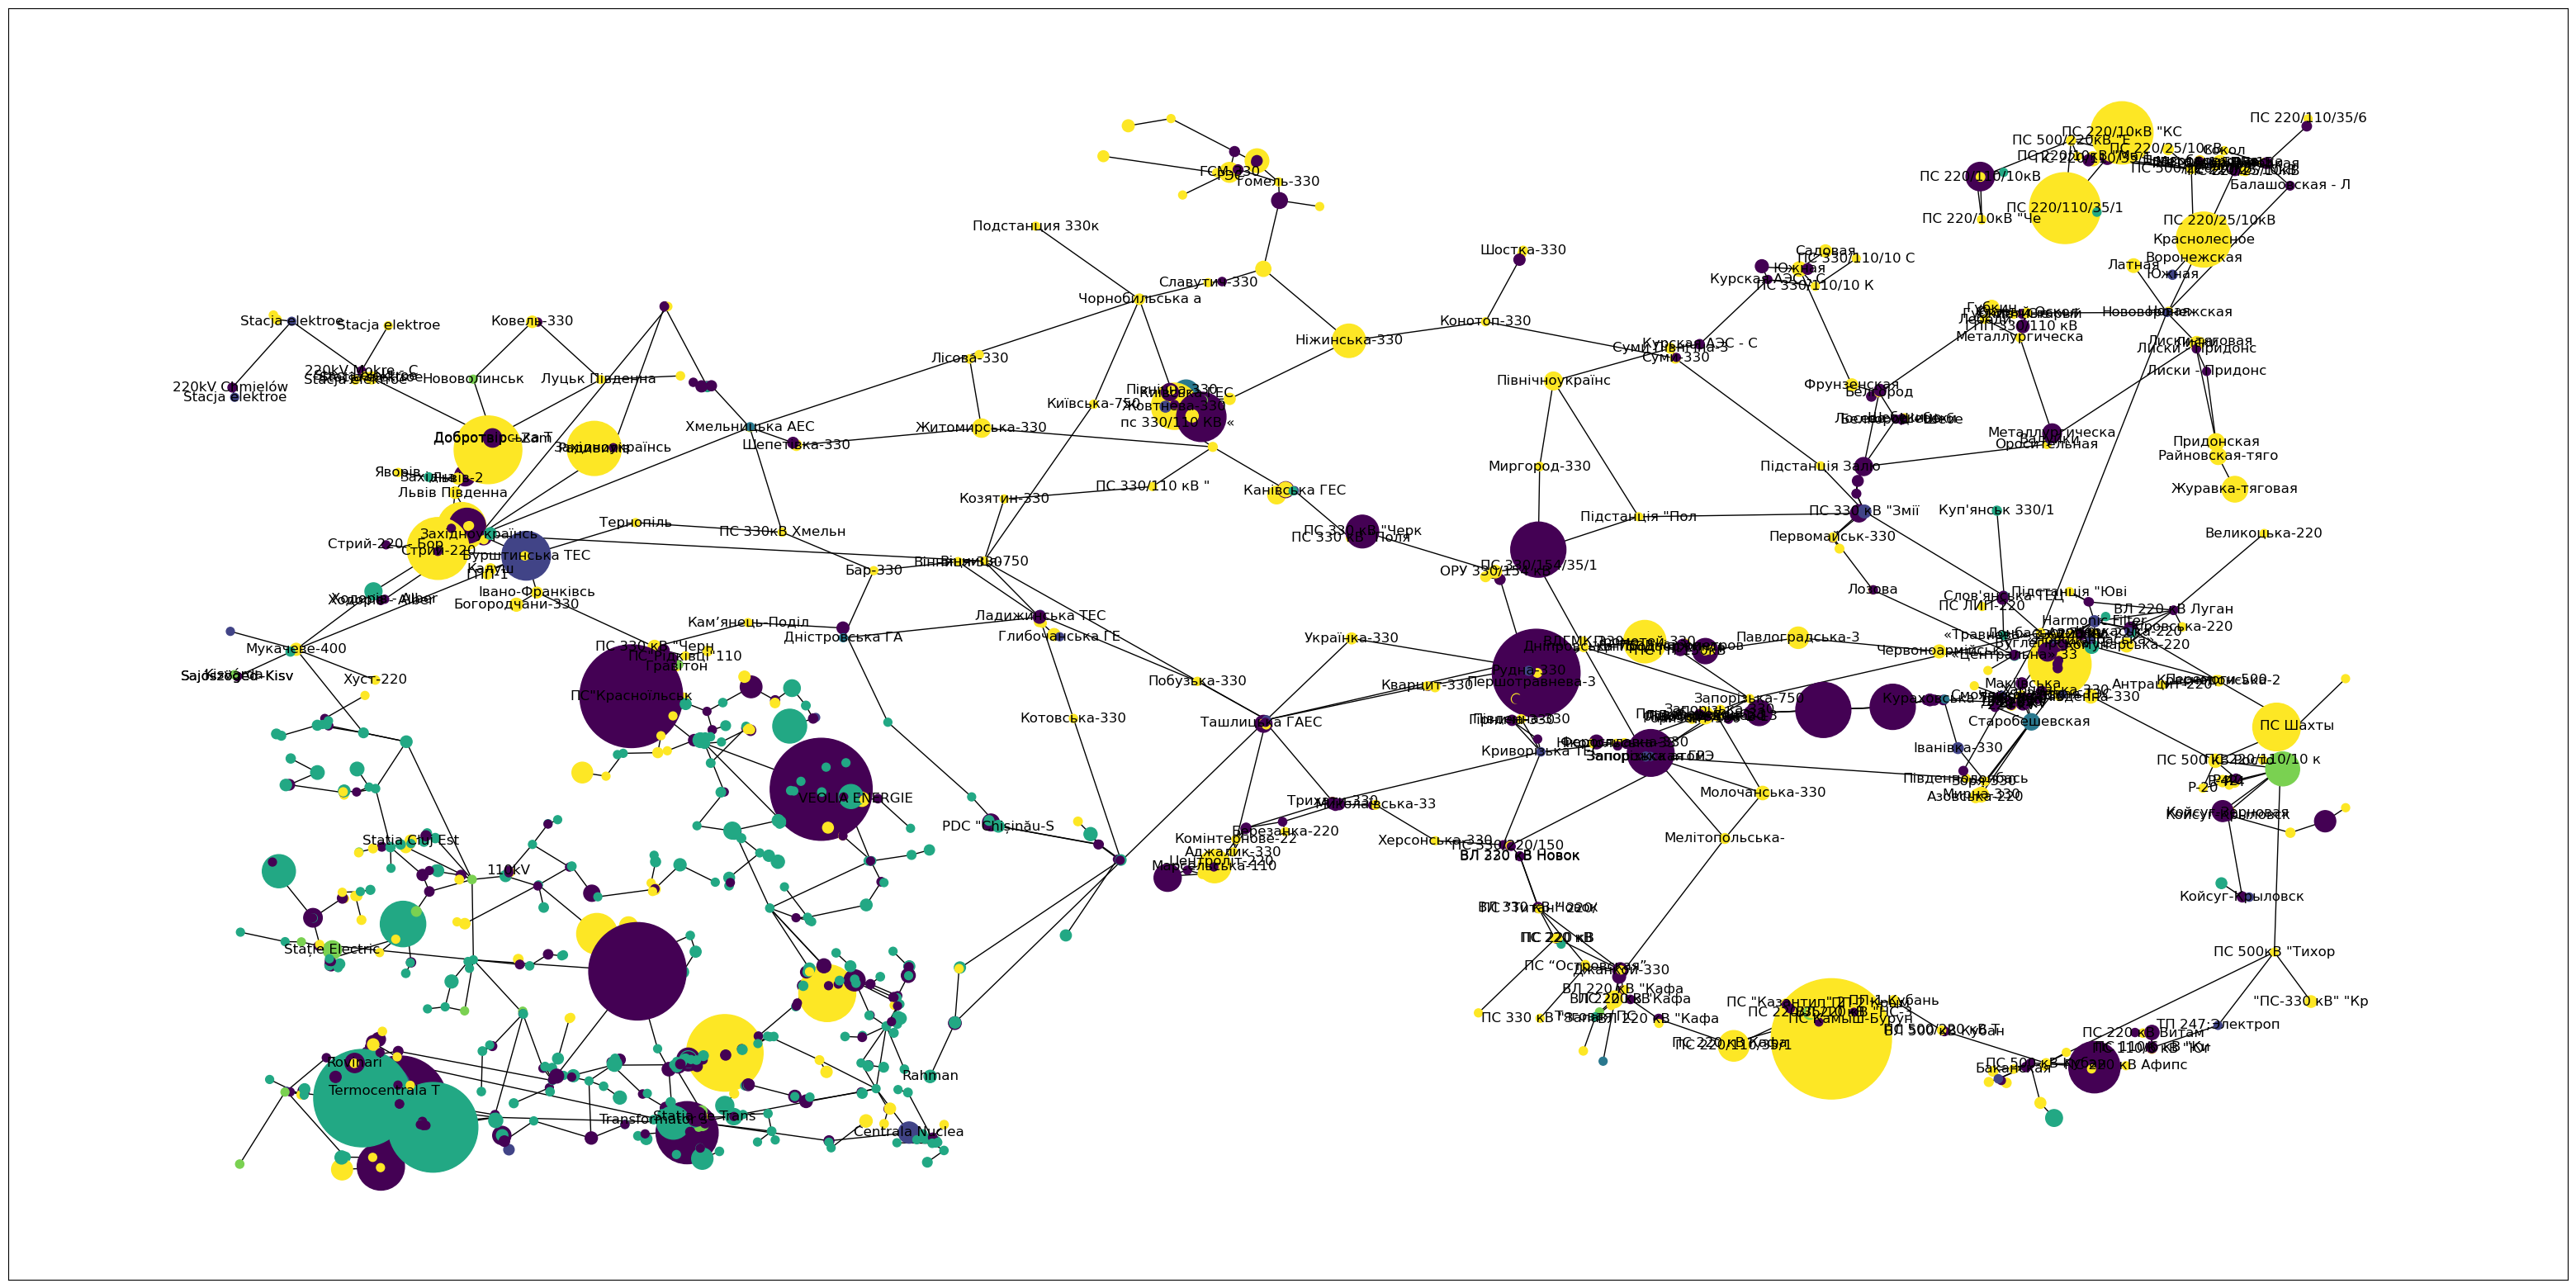

In [74]:
plt.figure(figsize=(40, 20))
nx.draw_networkx(
    g_ukr,
    pos={k: (v["lon"], v["lat"]) for k, v in g_ukr.nodes.data()},
    with_labels=True,
    labels={k: (v["name"][:15] if isinstance(v["name"], str) else "") for k, v in g_ukr.nodes.data()},
    node_color=[mapping_eu[v["typ"]] for k, v in g_ukr.nodes.data()],
    node_size=[(v + 0.001) * 50000 for k, v in nx.get_node_attributes(g_eu, "bc").items() if k in g_ukr.nodes]
)

In [75]:
m = 0
m = 3

m

3

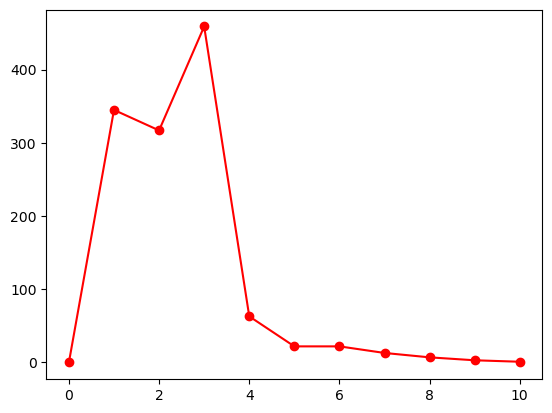

In [77]:
# degree_freq_eu = nx.degree_histogram(g_eu)
degree_freq_ukr = nx.degree_histogram(g_ukr)
degrees_ukr = range(len(degree_freq_ukr))
plt.plot(degrees_ukr[:], degree_freq_ukr[:],'ro-');

In [78]:
# Fit the degree distribution to the power law function using curve_fit
popt, pcov = curve_fit(power_law, degrees_ukr[m:], degree_freq_ukr[m:])
popt, pcov

(array([6.56016570e+00, 6.18448022e+05]),
 array([[1.92999141e-01, 1.31970922e+05],
        [1.31970922e+05, 9.04014964e+10]]))

In [79]:
# The first parameter of the fitted function is the exponent
alpha = popt[0]
alpha

6.560165698341277

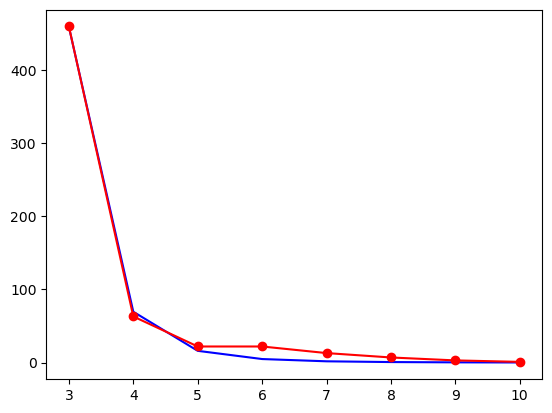

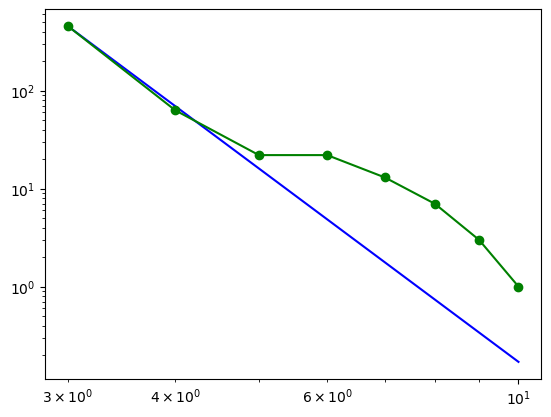

In [80]:
degree_freq_ukr = nx.degree_histogram(g_ukr)
degrees_ukr = range(len(degree_freq_ukr))
plt.plot(degrees_ukr[m:], power_law(degrees_ukr[m:], popt[0], popt[1]),'b-');
plt.plot(degrees_ukr[m:], degree_freq_ukr[m:],'ro-')
plt.show()
plt.plot(degrees_ukr[m:], power_law(degrees_ukr[m:], popt[0], popt[1]),'b-');
plt.loglog(degrees_ukr[m:], degree_freq_ukr[m:],'go-');

### USA

In [81]:
usa_nodes_df = pd.read_csv("./gridkit/gridkit_north_america-highvoltage-vertices.csv")
usa_nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   v_id           16174 non-null  int64  
 1   lon            16174 non-null  float64
 2   lat            16174 non-null  float64
 3   typ            16174 non-null  object 
 4   voltage        4427 non-null   object 
 5   frequency      2937 non-null   object 
 6   name           3579 non-null   object 
 7   operator       2579 non-null   object 
 8   ref            655 non-null    object 
 9   wkt_srid_4326  16174 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.2+ MB


In [82]:
usa_nodes_df.sample(5).T

6384   \
v_id                                                       14065   
lon                                                   -70.997447   
lat                                                    42.832505   
typ                                                   substation   
voltage                                                      NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(-70.9974474701564 42.832504634...   

                                                           260    \
v_id                                                        5331   
lon                                                   -90.276979   
lat                                                    29.977083   
typ                                                   substation   
voltage                                                   230000   
frequency                                                    NaN   
name                                           Kenner Substation   
operator                                                     NaN   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(-90.2769785603611 29.977083284...   

                                                           16048  \
v_id                                                       23674   
lon                                                  -114.141701   
lat                                                    48.365076   
typ                                                        joint   
voltage                                                   230000   
frequency                                                     60   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(-114.141700608352 48.365076195...   

                                                           15165  \
v_id                                                       23196   
lon                                                    -96.90456   
lat                                                    32.815975   
typ                                                        joint   
voltage                                                   345000   
frequency                                                     60   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
wkt_srid_4326  SRID=4326;POINT(-96.9045596878693 32.815974778...   

                                                           8004   
v_id                                                       10595  
lon                                                   -75.631357  
lat                                                    43.102076  
typ                                                  sub_station  
voltage                                                      NaN  
frequency                                                    NaN  
name                                                         NaN  
operator                                                     NaN  
ref                                                          NaN  
wkt_srid_4326  SRID=4326;POINT(-75.6313574171458 43.102076203...

In [83]:
usa_nodes_df["typ"].value_counts()

joint          6013
substation     3920
sub_station    2959
station        2194
merge          1033
plant            55
Name: typ, dtype: int64

In [84]:
usa_nodes_df.describe()

v_id           lon           lat
count  16174.00000  16174.000000  16174.000000
mean   15170.40664    -91.861795     38.203787
std     9382.13326     15.096270      6.768366
min        3.00000   -151.036867     14.867090
25%     6971.25000   -101.723079     33.824859
50%    15040.50000    -88.240357     38.826234
75%    23127.00000    -80.296317     42.946125
max    31339.00000    -52.728888     64.816065

In [85]:
usa_links_df = pd.read_csv("./gridkit/gridkit_north_america-highvoltage-links.csv")
usa_links_df = usa_links_df.dropna(axis=1, how="all")
usa_links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22459 entries, 0 to 22458
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   l_id           22459 non-null  int64  
 1   v_id_1         22459 non-null  int64  
 2   v_id_2         22459 non-null  int64  
 3   voltage        12932 non-null  object 
 4   cables         12570 non-null  object 
 5   wires          1870 non-null   object 
 6   frequency      8322 non-null   object 
 7   name           2611 non-null   object 
 8   operator       3370 non-null   object 
 9   ref            1552 non-null   object 
 10  length_m       22459 non-null  float64
 11  wkt_srid_4326  22459 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 2.1+ MB


In [86]:
usa_links_df.sample(5).T

8407   \
l_id                                                       23927   
v_id_1                                                     27451   
v_id_2                                                     27453   
voltage                                                   230000   
cables                                                         3   
wires                                                        NaN   
frequency                                                     60   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                              122.144118   
wkt_srid_4326  SRID=4326;LINESTRING(-99.2616718892472 19.8821...   

                                                           11361  \
l_id                                                        6016   
v_id_1                                                     19248   
v_id_2                                                     28612   
voltage                                                      NaN   
cables                                                         6   
wires                                                        NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                    PG&E   
ref                                        Placerville-Gold Hill   
length_m                                            12012.004404   
wkt_srid_4326  SRID=4326;LINESTRING(-120.947996474428 38.6601...   

                                                           22170  \
l_id                                                       15384   
v_id_1                                                      9214   
v_id_2                                                     23505   
voltage                                            345000;138000   
cables                                                        12   
wires                                                        NaN   
frequency                                                     60   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                             6128.514451   
wkt_srid_4326  SRID=4326;LINESTRING(-88.0595354269807 41.7565...   

                                                           19768  \
l_id                                                       24531   
v_id_1                                                      7877   
v_id_2                                                     19315   
voltage                                                   230000   
cables                                                       3;6   
wires                                                        NaN   
frequency                                                    NaN   
name                                                         NaN   
operator                                                     NaN   
ref                                                          NaN   
length_m                                             8411.080752   
wkt_srid_4326  SRID=4326;LINESTRING(-79.718996439257 43.64861...   

                                                           12422  
l_id                                                       29966  
v_id_1                                                      8758  
v_id_2                                                      6475  
voltage                                                   345000  
cables                                                       3;6  
wires                                                        NaN  
frequency                                         

In [87]:
g_usa = nx.Graph()
g_usa

In [88]:
for v1, v2 in zip(usa_links_df["v_id_1"], usa_links_df["v_id_2"]):
    g_usa.add_edge(v1, v2)
g_usa.number_of_nodes(), g_usa.number_of_edges()

(16167, 20242)

In [89]:
nx.set_node_attributes(g_usa, usa_nodes_df.set_index("v_id")[["lon", "lat", "name", "typ"]].to_dict("index"))

In [90]:
pos_usa = {k: (v["lon"], v["lat"]) for k, v in g_usa.nodes.data()}
len(pos_usa)

16167

In [91]:
groups_usa = set(nx.get_node_attributes(g_usa, 'typ').values())
mapping_usa = {v: k for k, v in enumerate(sorted(groups_usa))}
node_color_usa = [mapping_usa[v["typ"]] for k, v in g_usa.nodes.data()]
len(node_color_usa)

16167

In [92]:
mapping_usa

{'joint': 0,
 'merge': 1,
 'plant': 2,
 'station': 3,
 'sub_station': 4,
 'substation': 5}

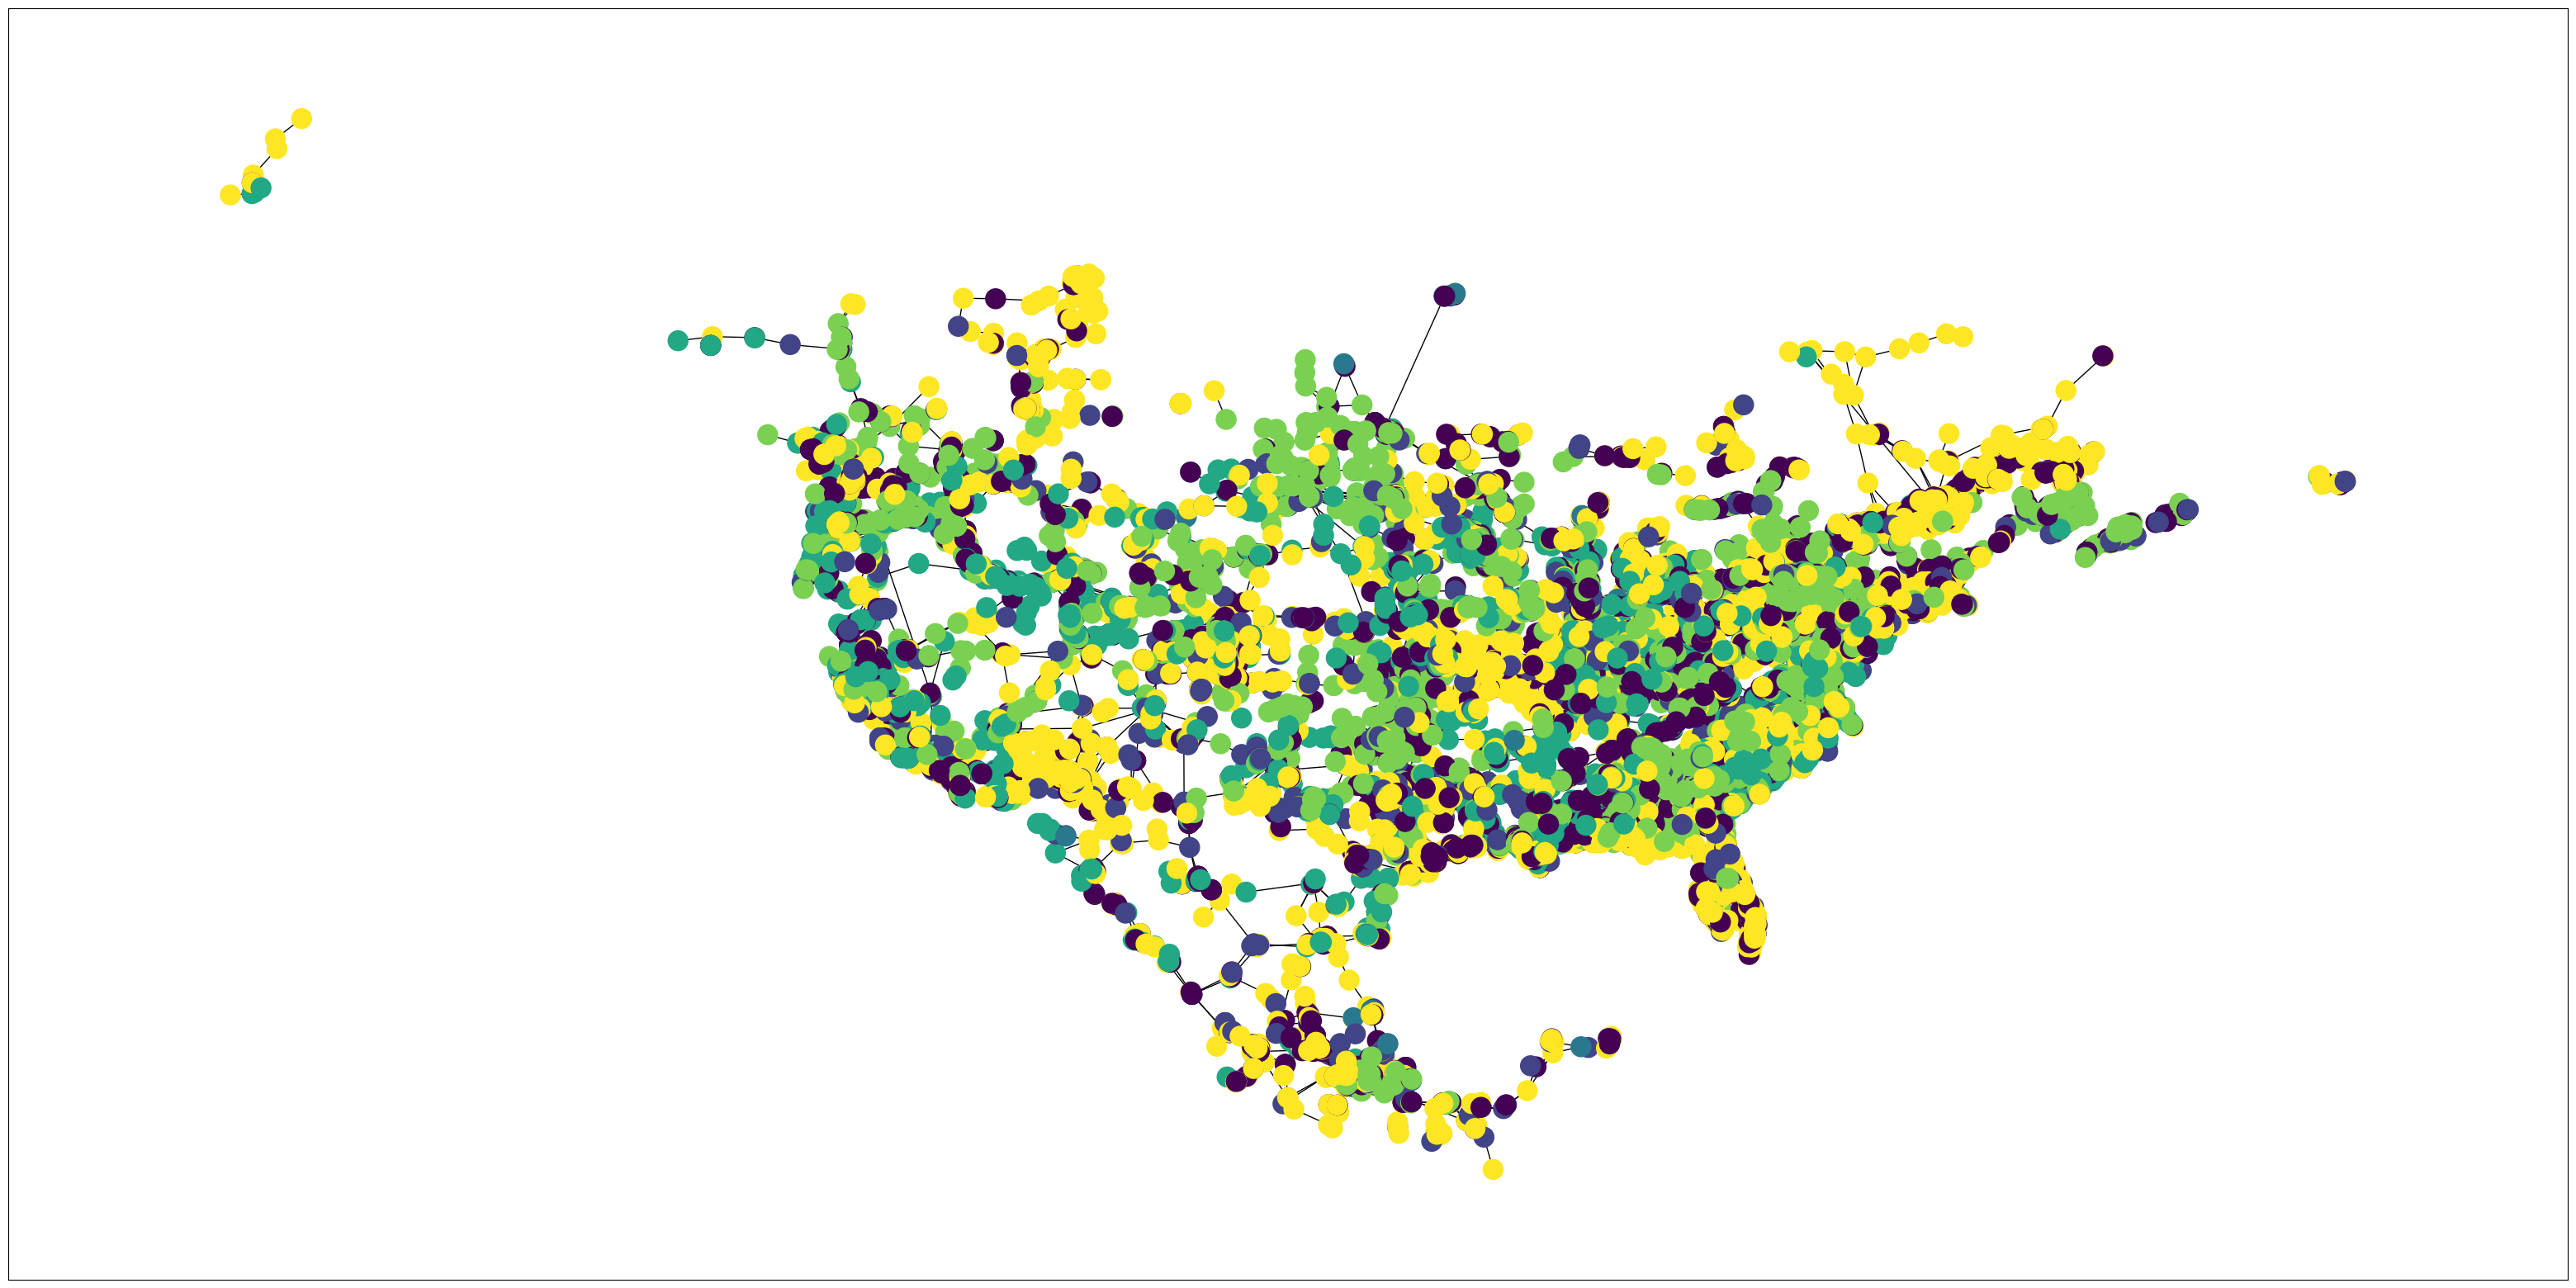

In [93]:
plt.figure(figsize=(40, 20))
nx.draw_networkx(
    g_usa,
    pos=pos_usa,
    with_labels=False,
    node_color=node_color_usa,
#     node_size=[(v + 0.001) * 0.001 for v in nx.get_node_attributes(g_usa, "bc")]
)

In [94]:
gccs_usa = sorted(nx.connected_components(g_usa), key=len, reverse=True)
len(gccs_usa)

34

In [95]:
for tmp_g in gccs_usa:
    tmp_g = nx.subgraph(g_usa, tmp_g)
    print(tmp_g.number_of_nodes(), tmp_g.number_of_edges())

14990 18804
736 973
152 174
49 58
41 52
38 39
25 28
22 22
21 21
10 9
8 7
5 4
5 5
5 4
4 3
4 3
4 3
4 3
4 3
4 3
4 4
3 3
3 2
3 2
3 2
3 2
3 2
2 1
2 1
2 1
2 1
2 1
2 1
2 1


In [96]:
gcc_usa = nx.subgraph(g_usa, gccs_usa[0])
# gcc_usa = nx.subgraph(g_usa, set(g_usa.nodes) - gccs_usa[0])  # oposite!
gcc_usa.number_of_nodes(), gcc_usa.number_of_edges()

(14990, 18804)

In [97]:
nx.set_node_attributes(g_usa, nx.degree_centrality(gcc_usa), "dc")
pd.Series(nx.get_node_attributes(gcc_usa, "dc").values()).describe(percentiles=DEFAULT_PERCENTILES);

In [103]:
%%time

# 11 or 40 mins!
nx.set_node_attributes(gcc_usa, nx.betweenness_centrality(gcc_usa, k=1_600), "bc")
pd.Series(nx.get_node_attributes(gcc_usa, "bc").values()).describe(percentiles=DEFAULT_PERCENTILES);

CPU times: user 1min 24s, sys: 286 ms, total: 1min 24s
Wall time: 1min 25s


In [100]:
%%time

# 21 mins!
nx.set_node_attributes(g_usa, nx.closeness_centrality(gcc_usa), "cc")
pd.Series(nx.get_node_attributes(gcc_usa, "cc").values()).describe(percentiles=DEFAULT_PERCENTILES);

KeyboardInterrupt: 

In [104]:
nx.set_node_attributes(g_usa, nx.eigenvector_centrality(gcc_usa), "ec")
pd.Series(nx.get_node_attributes(gcc_usa, "ec").values()).describe(percentiles=DEFAULT_PERCENTILES);

In [105]:
nx.set_node_attributes(g_usa, nx.pagerank(gcc_usa), "pc")
pd.Series(nx.get_node_attributes(gcc_usa, "pc").values()).describe(percentiles=DEFAULT_PERCENTILES);

In [106]:
len(nx.algorithms.community.louvain_communities(gcc_usa))

79

In [107]:
tmp_mapping = {}

for i, tmp_nodes in enumerate(nx.algorithms.community.louvain_communities(gcc_usa)):
    for tmp_node in tmp_nodes:
        tmp_mapping[tmp_node] = i
len(tmp_mapping)

14990

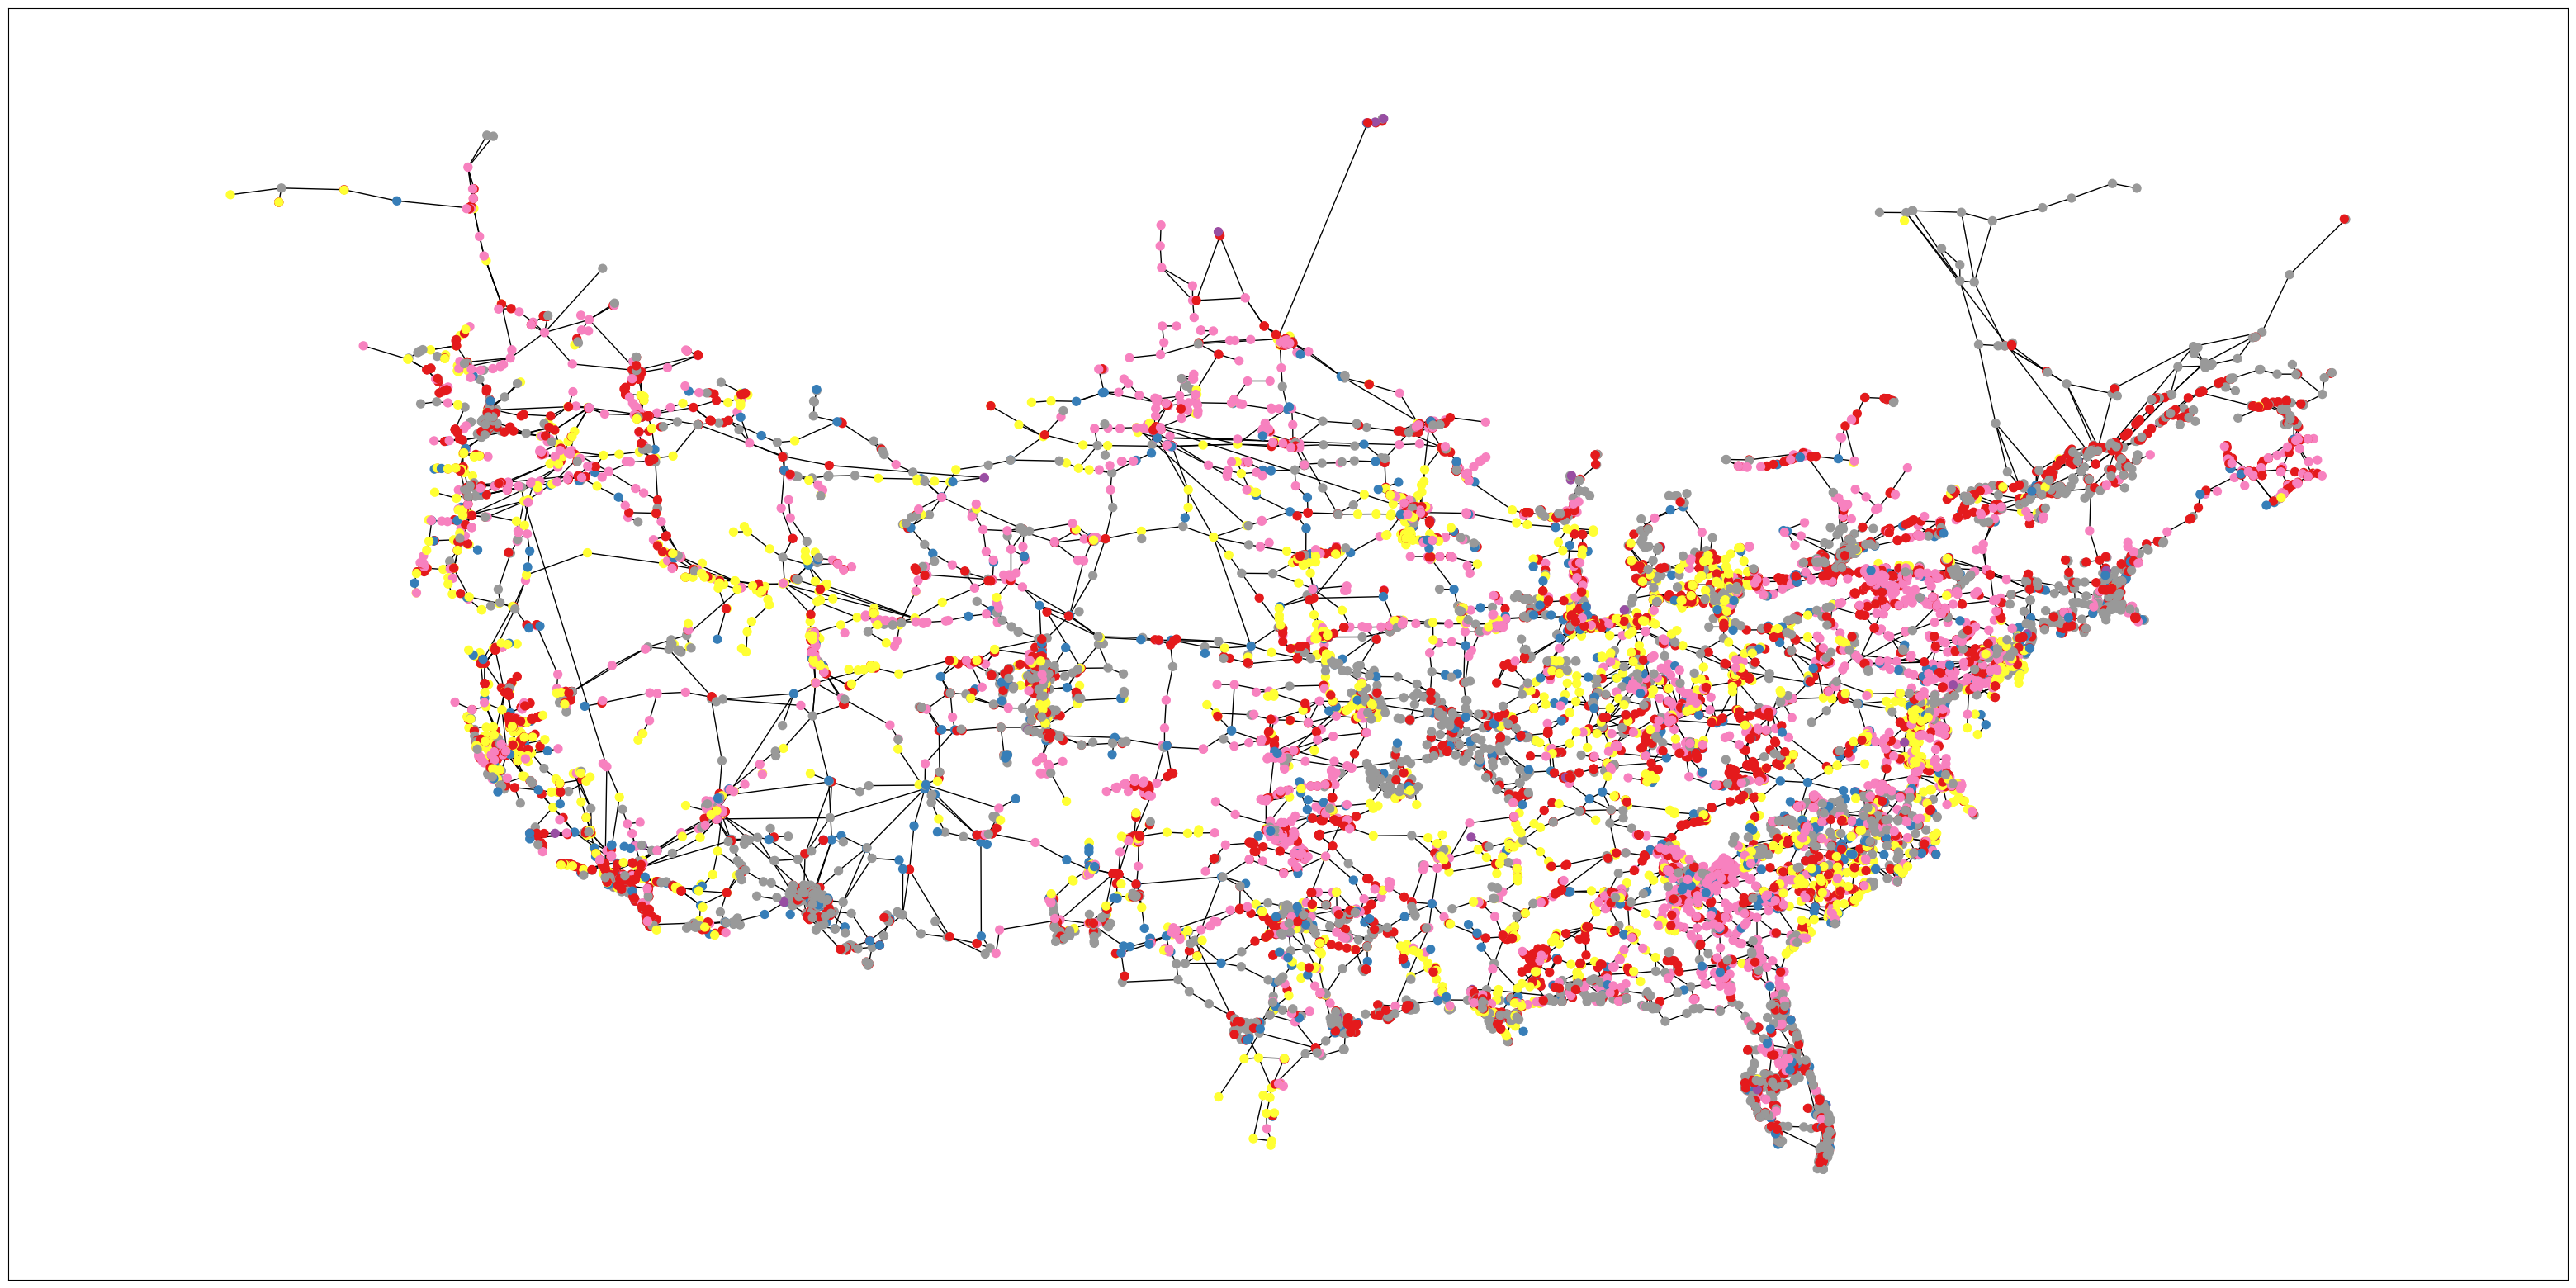

In [112]:
plt.figure(figsize=(40, 20))
nx.draw_networkx(
    gcc_usa,
    pos={k: (v["lon"], v["lat"]) for k, v in gcc_usa.nodes.data()},
    with_labels=False,
     labels={k: (v["name"][:15] if isinstance(v["name"], str) else "") for k, v in gcc_usa.nodes.data()},
    node_color=[mapping_usa[v["typ"]] for k, v in gcc_usa.nodes.data()],
#     node_color=[tmp_mapping[k] for k in gcc_usa.nodes],
#     node_color=[v for k, v in nx.degree(gcc_usa)],
    node_size=[(v + 0.01) * 5000 for k, v in nx.get_node_attributes(g_usa, "dc").items() if k in gcc_usa.nodes],
#     cmap="Reds",
#     cmap="tab20",
    cmap="Set1",
)

In [113]:
m = 0
m = 3

m

3

In [114]:
# degree_freq_usa = nx.degree_histogram(g_usa)
degree_freq_usa = nx.degree_histogram(gcc_usa)
degrees_usa = range(len(degree_freq_usa))

In [115]:
# Fit the degree distribution to the power law function using curve_fit
popt, pcov = curve_fit(power_law, degrees_usa[m:], degree_freq_usa[m:])
popt, pcov

(array([5.59869938e+00, 2.48759307e+06]),
 array([[9.55512242e-03, 2.64208346e+04],
        [2.64208346e+04, 7.32978834e+10]]))

In [116]:
# The first parameter of the fitted function is the exponent
alpha = popt[0]
alpha

5.5986993814885055

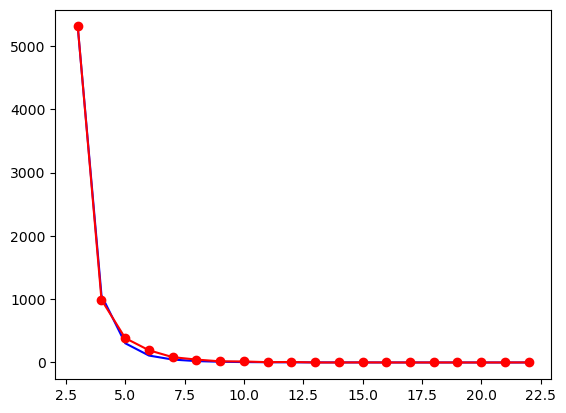

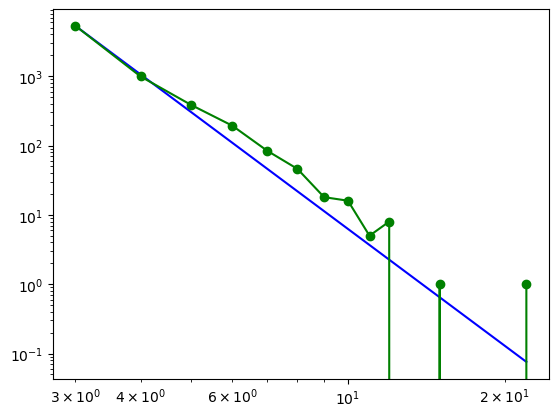

In [117]:
plt.plot(degrees_usa[m:], power_law(degrees_usa[m:], popt[0], popt[1]),'b-');
plt.plot(degrees_usa[m:], degree_freq_usa[m:],'ro-')
plt.show()
plt.plot(degrees_usa[m:], power_law(degrees_usa[m:], popt[0], popt[1]),'b-');
plt.loglog(degrees_usa[m:], degree_freq_usa[m:],'go-');

In [118]:
# diff. values!
alpha, intercept = alpha_lin_bins([d for _, d in gcc_usa.degree], 100)
alpha, intercept

(3.3936132069674216, 2.557418291900414)

In [119]:
centralities_usa = {}

In [120]:
centralities_usa["Degree Centrality"] = pd.Series(nx.get_node_attributes(gcc_usa, "dc"))

In [121]:
centralities_usa["Betweenness Centrality"] = pd.Series(nx.get_node_attributes(gcc_usa, "bc"))

In [122]:
centralities_usa["Eigenvector Centrality"] = pd.Series(nx.get_node_attributes(gcc_usa, "ec"))

In [123]:
centralities_usa["PageRank"] = pd.Series(nx.get_node_attributes(gcc_usa, "pc"))

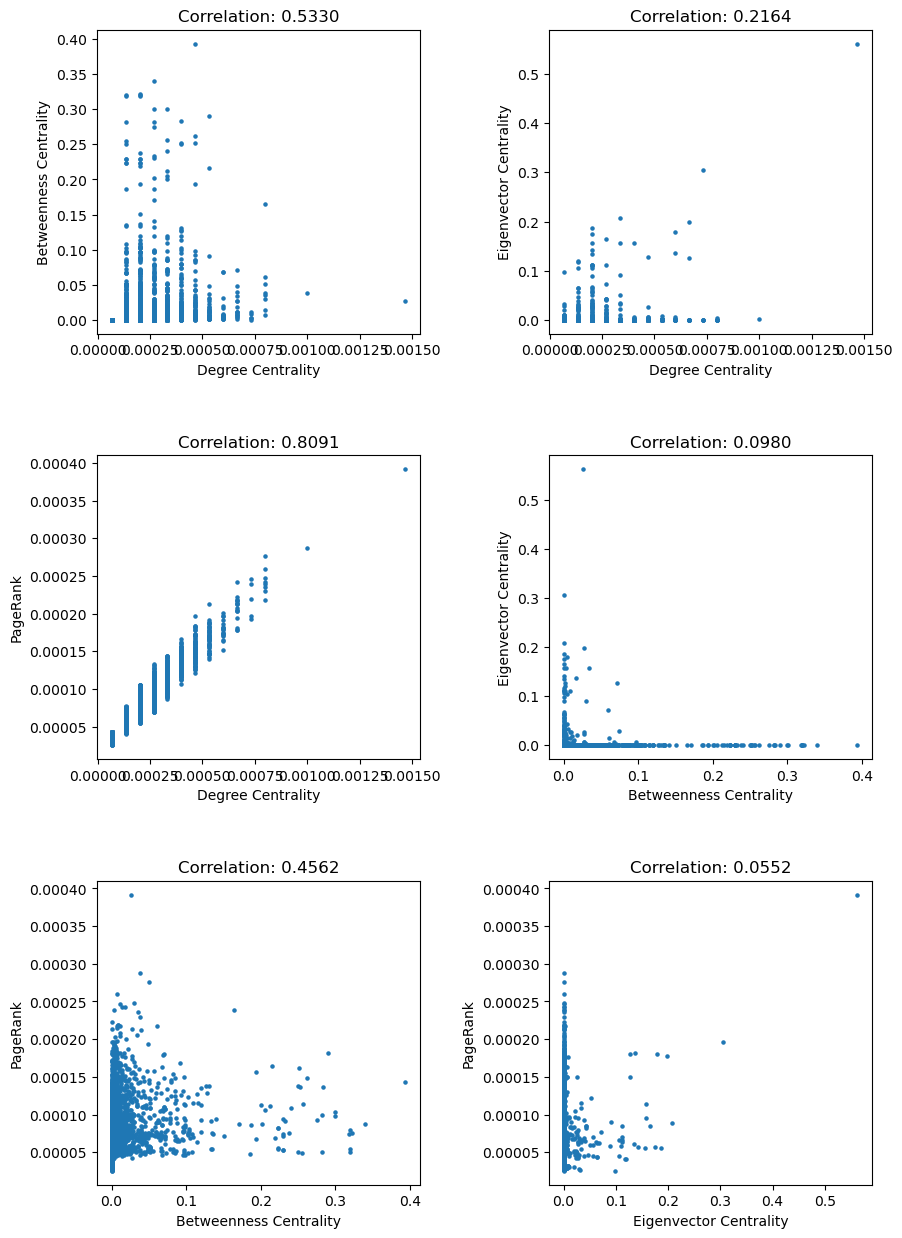

In [127]:
plt.figure(figsize=(2*5, 3*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(centralities_usa)):
    for j in range(i + 1, len(centralities_usa)):
        i_label, i_vals = list(centralities_usa.items())[i]
        j_label, j_vals = list(centralities_usa.items())[j]
        #correlation = np.corrcoef([i_vals, j_vals])[0][1]
        #correlation = scipy.stats.kendalltau(i_vals, j_vals)[0]
        #correlation = scipy.stats.spearmanr(i_vals, j_vals)[0]
        plt.subplot(3, 2, k)
        plt.scatter(i_vals, j_vals, s=5)
        plt.title('Correlation: {:.4f}'.format(correlation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

In [128]:
p_values = np.arange(0, 0.3, 0.01)
random_gcc_usa_sizes = []
degree_gcc_usa_sizes = []
betweenness_gcc_usa_sizes = []
eigenvector_gcc_usa_sizes = []
pagerank_gcc_usa_sizes = []

for p in p_values:
    # simulate random attack
    network_copy = gcc_usa.copy()
    network_copy = random_attack(network_copy, p)
    random_gcc_usa_sizes.append(calculate_gcc_size(network_copy))

    # simulate targeted attacks
    for centrality_name, centrality_measure in centralities_usa.items():
        network_copy = gcc_usa.copy()
        network_copy = targeted_attack(network_copy, centrality_measure, p)
        if centrality_name == 'Degree Centrality':
            degree_gcc_usa_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'Betweenness Centrality':
            betweenness_gcc_usa_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'Eigenvector Centrality':
            eigenvector_gcc_usa_sizes.append(calculate_gcc_size(network_copy))
        elif centrality_name == 'PageRank':
            pagerank_gcc_usa_sizes.append(calculate_gcc_size(network_copy))

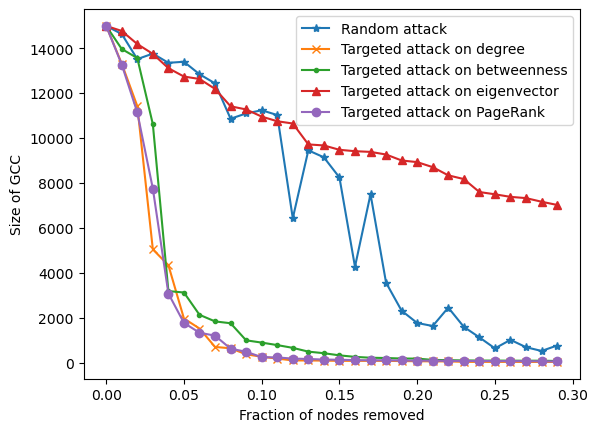

In [129]:
plt.plot(p_values, random_gcc_usa_sizes, label="Random attack", marker="*")
plt.plot(p_values, degree_gcc_usa_sizes, label="Targeted attack on degree", marker="x")
plt.plot(p_values, betweenness_gcc_usa_sizes, label="Targeted attack on betweenness", marker=".")
plt.plot(p_values, eigenvector_gcc_usa_sizes, label="Targeted attack on eigenvector", marker="^")
plt.plot(p_values, pagerank_gcc_usa_sizes, label="Targeted attack on PageRank", marker="o")
plt.xlabel("Fraction of nodes removed")
plt.ylabel("Size of GCC")
plt.legend()
plt.show()